In [15]:
# Cell 0: Environment Setup
# Install required dependencies from requirements.txt
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [16]:
# Cell 1: Imports and Configuration
# Import necessary libraries, configure paths, and set up ML parameters
# - Core portfolio optimization modules
# - Data handling and visualization tools  
# - Symbol definitions and ML configuration

from __future__ import annotations

import os
import math
import time
import logging

import pandas as pd
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
import matplotlib.pyplot as plt

from portfolio.data.yahoo_service import YahooFinanceService
from portfolio.optimizer.optimizer import SimplePortfolioOptimizer
from portfolio.performance.calculator import SimplePerformanceCalculator
from portfolio.performance.visualization import (
    plot_equity_curve,
    plot_drawdown_curve,
)

# Symbols and period
symbols = [
    "AAPL", "MSFT", "GOOGL", "AMZN",
    "META", "NVDA", "NFLX", "TSLA",
    "JPM", "JNJ", "PG", "HD",
    "DIS", "V", "MA", "UNH",
]
# Use longer history by default to stabilize risk estimates
period = "10y"

# Output paths
FIG_DIR = os.path.join("examples", "figures")
OUT_DIR = os.path.join("examples", "outputs")
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)

# ML Configuration
ML_SYMBOLS = ["AAPL", "MSFT", "GOOGL", "AMZN", "META", "NVDA", "TSLA", "V", "MA", "JPM", "JNJ", "PG", "HD", "DIS", "NFLX", "ADBE"]
ML_PERIOD = "10y"
ML_DEVICE = "cpu"
ML_MODEL = "xgb"
ML_MIN_SAMPLES = 100

plt.style.use("seaborn-v0_8-whitegrid")
print(f"Symbols: {symbols}, Period: {period}")
print(f"ML Symbols: {ML_SYMBOLS}, Model: {ML_MODEL}, Device: {ML_DEVICE}")

Symbols: ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA', 'NFLX', 'TSLA', 'JPM', 'JNJ', 'PG', 'HD', 'DIS', 'V', 'MA', 'UNH'], Period: 10y
ML Symbols: ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA', 'TSLA', 'V', 'MA', 'JPM', 'JNJ', 'PG', 'HD', 'DIS', 'NFLX', 'ADBE'], Model: xgb, Device: cpu


In [17]:
# Cell 2: Data Fetching and Quality Assessment
# - Fetch historical price data from Yahoo Finance API
# - Use offline cache when available for efficiency
# - Rebuild combined data if symbols are missing
# - Generate data quality reports for each symbol

# Data fetch and quick QA
service = YahooFinanceService(use_offline_data=True, offline_data_dir="data")

# Show available offline cache (raw/processed/combined)
available = service.list_available_offline_data()
print("Offline data files:", {k: len(v) for k, v in available.items()})

# Consolidated adjusted close prices for selected symbols
prices = service.fetch_price_data(symbols, period)

# If the combined cache doesn't include all symbols, rebuild from per-symbol offline data
if prices.shape[1] < len(symbols):
    cols = []
    for s in symbols:
        try:
            df = service.fetch_historical_data(s, period)
            if not df.empty and "Adj Close" in df:
                cols.append(df["Adj Close"].rename(s))
        except Exception as e:
            print(f"Missing or failed for {s}: {e}")
    if cols:
        rebuilt = pd.concat(cols, axis=1).dropna()
        missing = [s for s in symbols if s not in rebuilt.columns]
        if missing:
            print("Symbols missing in rebuilt combined:", missing)
        prices = rebuilt

print("Prices shape:", prices.shape)
print(prices.head())
start_date = (prices.index.min()).strftime("%Y-%m-%d")
end_date = (prices.index.max()).strftime("%Y-%m-%d")
print("Backtest window:", start_date, "to", end_date)

# Per-symbol pipeline and quality report preview
pipeline = service.fetch_and_process_data(symbols, period)

rows = []
for sym, res in pipeline.items():
    if res.get("success"):
        q = res.get("quality_report", {})
        rows.append({
            "symbol": sym,
            "rows": q.get("data_summary", {}).get("total_rows"),
            "completeness": q.get("quality_metrics", {}).get("completeness"),
            "vol_annualized": q.get("quality_metrics", {}).get("volatility_annualized"),
        })
summary = pd.DataFrame(rows).set_index("symbol").sort_index()
print(summary.to_string())

2025-09-29 19:59:59,187 - portfolio.data.yahoo_service - INFO - Initialized YahooFinanceService
2025-09-29 19:59:59,198 - portfolio.data.yahoo_service - INFO - Loaded offline combined price data for 16/16 symbols
2025-09-29 19:59:59,203 - portfolio.data.yahoo_service - INFO - Processing data for AAPL
2025-09-29 19:59:59,210 - portfolio.data.yahoo_service - INFO - Loaded offline data for AAPL (10y): 2514 rows
2025-09-29 19:59:59,215 - portfolio.data.yahoo_service - INFO - Cleaned data: 2514 -> 2514 rows
2025-09-29 19:59:59,244 - portfolio.data.yahoo_service - INFO - Generated quality report for AAPL
2025-09-29 19:59:59,245 - portfolio.data.yahoo_service - INFO - Successfully processed data for AAPL
2025-09-29 19:59:59,245 - portfolio.data.yahoo_service - INFO - Processing data for MSFT
2025-09-29 19:59:59,253 - portfolio.data.yahoo_service - INFO - Loaded offline data for MSFT (10y): 2514 rows
2025-09-29 19:59:59,258 - portfolio.data.yahoo_service - INFO - Cleaned data: 2514 -> 2514 row

Offline data files: {'raw': 36, 'processed': 4, 'combined': 4}
Prices shape: (2514, 16)
                 AAPL       MSFT      GOOGL       AMZN       META      NVDA  \
Date                                                                          
2015-09-25  25.778269  38.288254  31.788252  26.212500  92.201599  0.573762   
2015-09-28  25.268143  37.721863  30.998699  25.202999  88.663406  0.566229   
2015-09-29  24.508562  37.852573  30.917263  24.803499  86.138985  0.576192   
2015-09-30  24.787235  38.567112  31.699863  25.594500  89.349190  0.599036   
2015-10-01  24.625429  38.872086  31.880117  26.035999  90.392761  0.587371   

                  NFLX       TSLA        JPM        JNJ         PG         HD  \
Date                                                                            
2015-09-25  102.239998  17.127333  46.792572  68.916824  55.088547  92.186150   
2015-09-28   99.470001  16.562000  45.658333  69.197083  54.406300  90.101387   
2015-09-29   98.349998  16.443333 

2025-09-29 19:59:59,372 - portfolio.data.yahoo_service - INFO - Generated quality report for AMZN
2025-09-29 19:59:59,373 - portfolio.data.yahoo_service - INFO - Successfully processed data for AMZN
2025-09-29 19:59:59,373 - portfolio.data.yahoo_service - INFO - Processing data for META
2025-09-29 19:59:59,380 - portfolio.data.yahoo_service - INFO - Loaded offline data for META (10y): 2514 rows
2025-09-29 19:59:59,384 - portfolio.data.yahoo_service - INFO - Cleaned data: 2514 -> 2514 rows
2025-09-29 19:59:59,412 - portfolio.data.yahoo_service - INFO - Generated quality report for META
2025-09-29 19:59:59,413 - portfolio.data.yahoo_service - INFO - Successfully processed data for META
2025-09-29 19:59:59,413 - portfolio.data.yahoo_service - INFO - Processing data for NVDA
2025-09-29 19:59:59,420 - portfolio.data.yahoo_service - INFO - Loaded offline data for NVDA (10y): 2514 rows
2025-09-29 19:59:59,424 - portfolio.data.yahoo_service - INFO - Cleaned data: 2514 -> 2514 rows
2025-09-29 1

        rows  completeness  vol_annualized
symbol                                    
AAPL    2514           1.0        0.292105
AMZN    2514           1.0        0.327837
DIS     2514           1.0        0.284588
GOOGL   2514           1.0        0.286895
HD      2514           1.0        0.245323
JNJ     2514           1.0        0.183612
JPM     2514           1.0        0.276172
MA      2514           1.0        0.269051
META    2514           1.0        0.384085
MSFT    2514           1.0        0.269548
NFLX    2514           1.0        0.422336
NVDA    2514           1.0        0.499052
PG      2514           1.0        0.187084
TSLA    2514           1.0        0.592329
UNH     2514           1.0        0.290954
V       2514           1.0        0.246139


In [18]:
# Cell 3: Returns Computation and Correlation Analysis
# - Calculate daily returns from price data
# - Display descriptive statistics (mean, standard deviation)
# - Compute and display correlation matrix between all assets
# - Provides insights into asset relationships for portfolio construction

# Returns computation
asset_returns = prices.pct_change().dropna()
print("Returns shape:", asset_returns.shape)
print(asset_returns.describe().T[["mean", "std"]])

corr = asset_returns.corr()
print("Pairwise correlations:")
print(corr)

Returns shape: (2513, 16)
           mean       std
AAPL   0.001077  0.018400
MSFT   0.001175  0.016980
GOOGL  0.000980  0.018069
AMZN   0.001060  0.020641
META   0.001135  0.024187
NVDA   0.002773  0.031442
NFLX   0.001343  0.026604
TSLA   0.001988  0.037314
JPM    0.000908  0.017393
JNJ    0.000442  0.011569
PG     0.000474  0.011785
HD     0.000714  0.015450
DIS    0.000241  0.017927
V      0.000771  0.015476
MA     0.000895  0.016939
UNH    0.000674  0.018321
Pairwise correlations:
           AAPL      MSFT     GOOGL      AMZN      META      NVDA      NFLX  \
AAPL   1.000000  0.678221  0.612246  0.576512  0.525135  0.536719  0.427289   
MSFT   0.678221  1.000000  0.719159  0.672841  0.600693  0.614228  0.486353   
GOOGL  0.612246  0.719159  1.000000  0.651249  0.627010  0.542570  0.454672   
AMZN   0.576512  0.672841  0.651249  1.000000  0.618231  0.536250  0.528796   
META   0.525135  0.600693  0.627010  0.618231  1.000000  0.491132  0.464599   
NVDA   0.536719  0.614228  0.542570

In [19]:
# Cell 4: Comprehensive Optimization Methods Comparison
# 
# OPTIMIZATION METHODS EXPLAINED:
# 
# 1. Mean-Variance Optimization (MVO): 
#    - Classic Markowitz approach maximizing risk-adjusted returns
#    - Uses Ledoit-Wolf shrinkage for robust covariance estimation
#    - 18% weight cap prevents excessive concentration
#    - 3% entropy penalty encourages diversification
# 
# 2. CVaR (Conditional Value-at-Risk) Optimization:
#    - Focuses on tail risk management (95% confidence level)
#    - Minimizes expected losses beyond worst 5% scenarios
#    - More robust to outliers than standard deviation
#    - Particularly useful for downside-focused investors
# 
# 3. Black-Litterman Optimization:
#    - Combines market equilibrium with investor views
#    - Uses historical returns as prior, shrinks toward market weights
#    - More stable than pure MVO, less sensitive to input changes
#    - Good when you have some market views but want anchoring
# 
# 4. Risk Parity:
#    - Equal risk contribution approach (not equal weights)
#    - Each asset contributes equally to portfolio volatility
#    - Naturally diversifies across risk sources
#    - More stable performance across market regimes
# 
# PERFORMANCE COMPARISON:
# - Fetch SPY benchmark data for performance comparison
# - Calculate key metrics: Sharpe ratio, returns, volatility, drawdown
# - Display comprehensive comparison table and rankings
# - Analyze portfolio composition and concentration
# - Method tradeoffs: return vs stability, complexity vs interpretability

print("=== Portfolio Optimization Methods Comparison ===")

# Initialize optimizer and performance calculator
opt = SimplePortfolioOptimizer()
perf = SimplePerformanceCalculator()

# Fetch SPY benchmark data for performance comparison
try:
    spy_data = service.fetch_historical_data('SPY', period=period)
    if not spy_data.empty and 'Adj Close' in spy_data:
        benchmark_returns = spy_data['Adj Close'].pct_change().dropna()
        print(f"SPY benchmark data loaded: {len(benchmark_returns)} observations")
    else:
        benchmark_returns = None
        print("Warning: SPY benchmark data not available")
except Exception as e:
    benchmark_returns = None
    print(f"Warning: Could not fetch SPY data: {e}")

# Execute comprehensive optimization analysis
results = {}

print("\n=== Running Comprehensive Optimization Analysis ===")

# 1. Mean-Variance Optimization (MVO)
print("\n1. Running Mean-Variance Optimization...")
try:
    mvo_result = opt.mean_variance_optimize(
        asset_returns,
        risk_model="ledoit_wolf",
        weight_cap=0.18,
        entropy_penalty=0.03
    )
    mvo_weights = pd.Series(mvo_result['weights'], index=asset_returns.columns)
    mvo_returns = (asset_returns * mvo_weights).sum(axis=1)
    mvo_metrics = perf.calculate_metrics(mvo_returns, benchmark_returns)
    
    results['MVO'] = {
        'weights': mvo_weights,
        'returns': mvo_returns,
        'metrics': mvo_metrics,
        'optimization_result': mvo_result
    }
    print(f"   Expected Sharpe: {mvo_result.get('sharpe_ratio', 0):.3f}")
    print(f"   Realized Sharpe: {mvo_metrics['sharpe_ratio']:.3f}")
except Exception as e:
    print(f"   Error in MVO: {e}")

# 2. CVaR Optimization
print("\n2. Running CVaR Optimization...")
try:
    cvar_result = opt.cvar_optimize(asset_returns, alpha=0.05)
    cvar_weights = pd.Series(cvar_result['weights'], index=asset_returns.columns)
    cvar_returns = (asset_returns * cvar_weights).sum(axis=1)
    cvar_metrics = perf.calculate_metrics(cvar_returns, benchmark_returns)
    
    results['CVaR'] = {
        'weights': cvar_weights,
        'returns': cvar_returns,
        'metrics': cvar_metrics,
        'optimization_result': cvar_result
    }
    print(f"   Expected Sharpe: {cvar_result.get('sharpe_ratio', 0):.3f}")
    print(f"   Realized Sharpe: {cvar_metrics['sharpe_ratio']:.3f}")
except Exception as e:
    print(f"   Error in CVaR: {e}")

# 3. Black-Litterman Optimization
print("\n3. Running Black-Litterman Optimization...")
try:
    # Use equal weights as market prior (neutral views)
    bl_result = opt.black_litterman_optimize(
        asset_returns,
        tau=0.05
    )
    bl_weights = pd.Series(bl_result['weights'], index=asset_returns.columns)
    bl_returns = (asset_returns * bl_weights).sum(axis=1)
    bl_metrics = perf.calculate_metrics(bl_returns, benchmark_returns)
    
    results['Black-Litterman'] = {
        'weights': bl_weights,
        'returns': bl_returns,
        'metrics': bl_metrics,
        'optimization_result': bl_result
    }
    print(f"   Expected Sharpe: {bl_result.get('sharpe_ratio', 0):.3f}")
    print(f"   Realized Sharpe: {bl_metrics['sharpe_ratio']:.3f}")
except Exception as e:
    print(f"   Error in Black-Litterman: {e}")

# 4. Risk Parity (simplified implementation)
print("\n4. Running Risk Parity Optimization...")
try:
    # Simple risk parity implementation using inverse volatility
    volatilities = asset_returns.std() * np.sqrt(252)  # Annualized volatilities
    inv_vol = 1 / volatilities
    rp_weights = inv_vol / inv_vol.sum()  # Normalize to sum to 1
    
    rp_returns = (asset_returns * rp_weights).sum(axis=1)
    rp_metrics = perf.calculate_metrics(rp_returns, benchmark_returns)
    
    # Create a simple result dict for consistency
    rp_result = {
        'weights': rp_weights.to_dict(),
        'expected_return': float(rp_metrics.get('annual_return', 0)),
        'expected_volatility': float(rp_metrics.get('annual_volatility', 0)),
        'sharpe_ratio': float(rp_metrics.get('sharpe_ratio', 0))
    }
    
    results['Risk Parity'] = {
        'weights': rp_weights,
        'returns': rp_returns,
        'metrics': rp_metrics,
        'optimization_result': rp_result
    }
    print(f"   Realized Sharpe: {rp_metrics['sharpe_ratio']:.3f}")
except Exception as e:
    print(f"   Error in Risk Parity: {e}")

# Display comprehensive comparison table
print("\n=== Optimization Methods Comparison ===")

comparison_data = []
for method, data in results.items():
    metrics = data['metrics']
    comparison_data.append({
        'Method': method,
        'Annual Return': f"{metrics['annual_return']:.2%}",
        'Annual Volatility': f"{metrics['annual_volatility']:.2%}",
        'Sharpe Ratio': f"{metrics['sharpe_ratio']:.3f}",
        'Max Drawdown': f"{metrics['max_drawdown']:.2%}",
        'Win Rate': f"{metrics.get('win_rate', 0):.1%}",
        'Top Holding': data['weights'].idxmax(),
        'Top Weight': f"{data['weights'].max():.1%}"
    })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# Display top holdings for each method
print("\n=== Top Holdings by Method ===")
for method, data in results.items():
    print(f"\n{method}:")
    top_weights = data['weights'].sort_values(ascending=False).head(5)
    for asset, weight in top_weights.items():
        print(f"  {asset}: {weight:.1%}")

print(f"\n✓ Comprehensive optimization completed successfully!")
print(f"✓ Results stored in 'results' variable for visualization")

2025-09-29 19:59:59,903 - portfolio.optimizer.optimizer - INFO - Initialized SimplePortfolioOptimizer
2025-09-29 19:59:59,912 - portfolio.data.yahoo_service - INFO - Loaded offline data for SPY (10y): 2514 rows


=== Portfolio Optimization Methods Comparison ===
SPY benchmark data loaded: 2513 observations

=== Running Comprehensive Optimization Analysis ===

1. Running Mean-Variance Optimization...
   Expected Sharpe: 1.275
   Realized Sharpe: 1.357

2. Running CVaR Optimization...
   Expected Sharpe: 1.347
   Realized Sharpe: 1.442

3. Running Black-Litterman Optimization...
   Expected Sharpe: 1.290
   Realized Sharpe: 1.380

4. Running Risk Parity Optimization...
   Realized Sharpe: 1.113

=== Optimization Methods Comparison ===
         Method Annual Return Annual Volatility Sharpe Ratio Max Drawdown Win Rate Top Holding Top Weight
            MVO        42.61%            29.92%        1.357      -48.88%    56.2%        NVDA      18.0%
           CVaR        29.55%            19.10%        1.442      -32.06%    56.8%          PG      26.7%
Black-Litterman        46.12%            31.97%        1.380      -51.08%    56.7%        NVDA      27.0%
    Risk Parity        23.43%            19.25

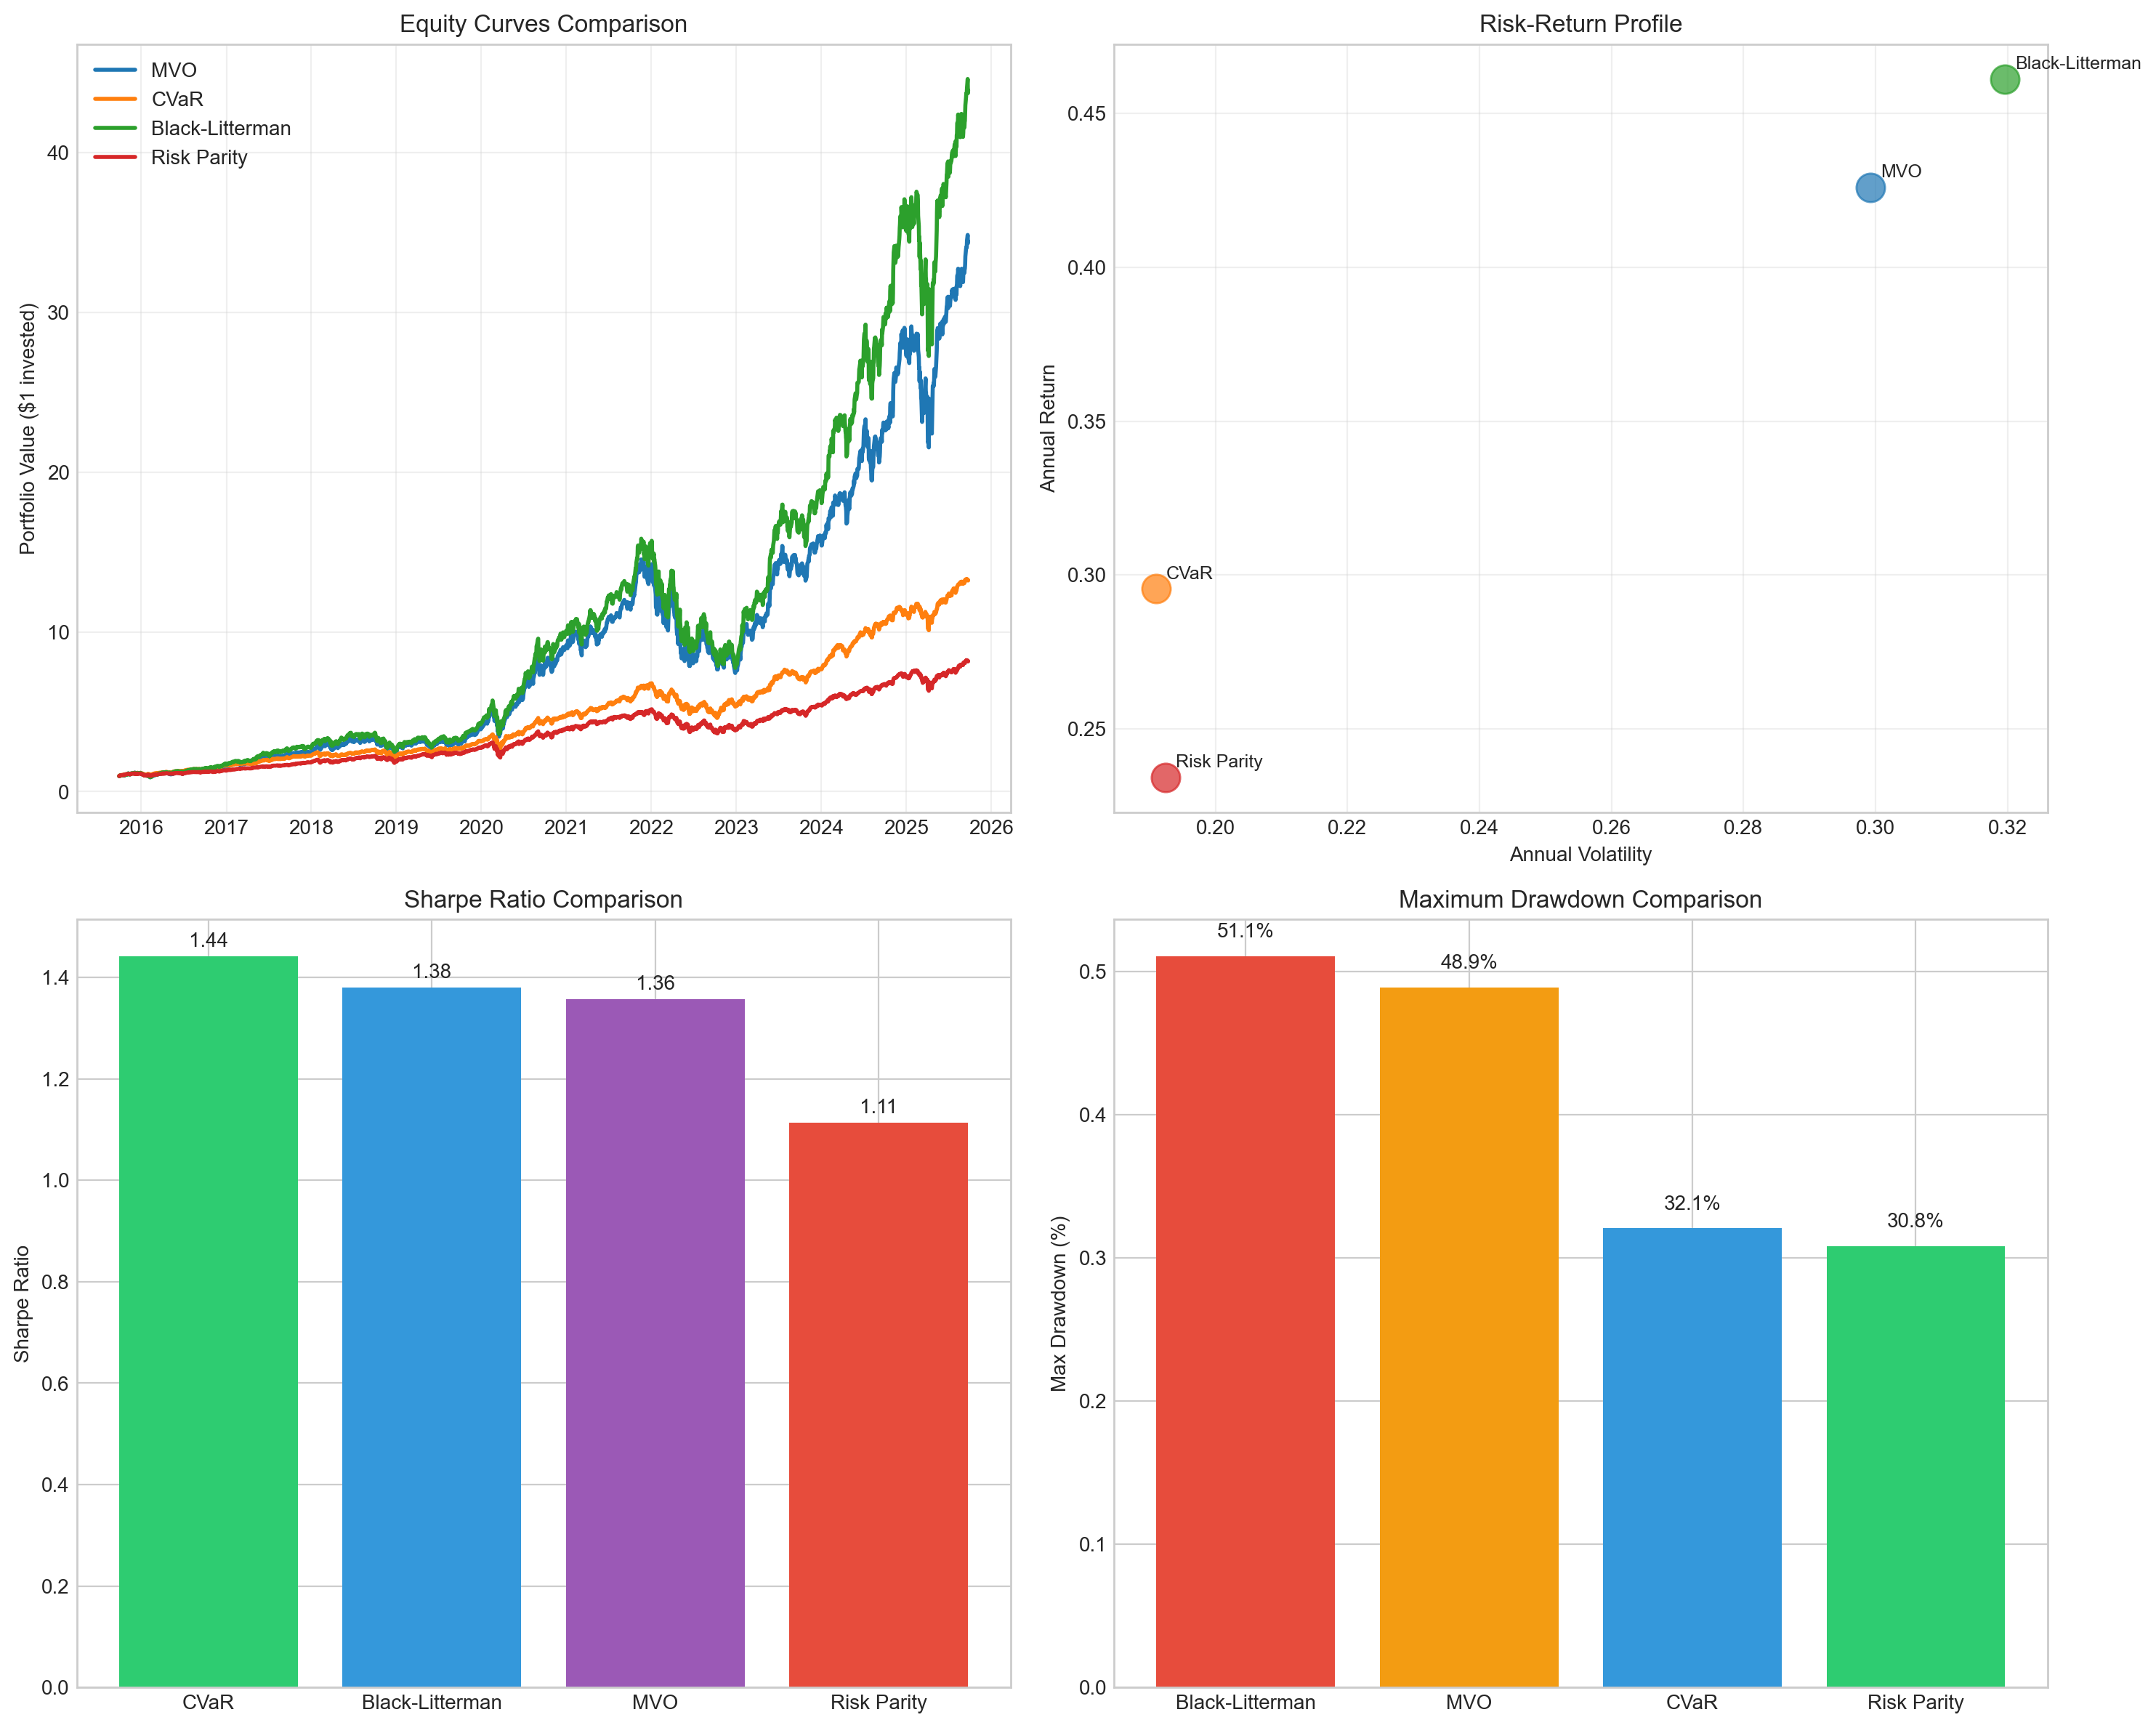

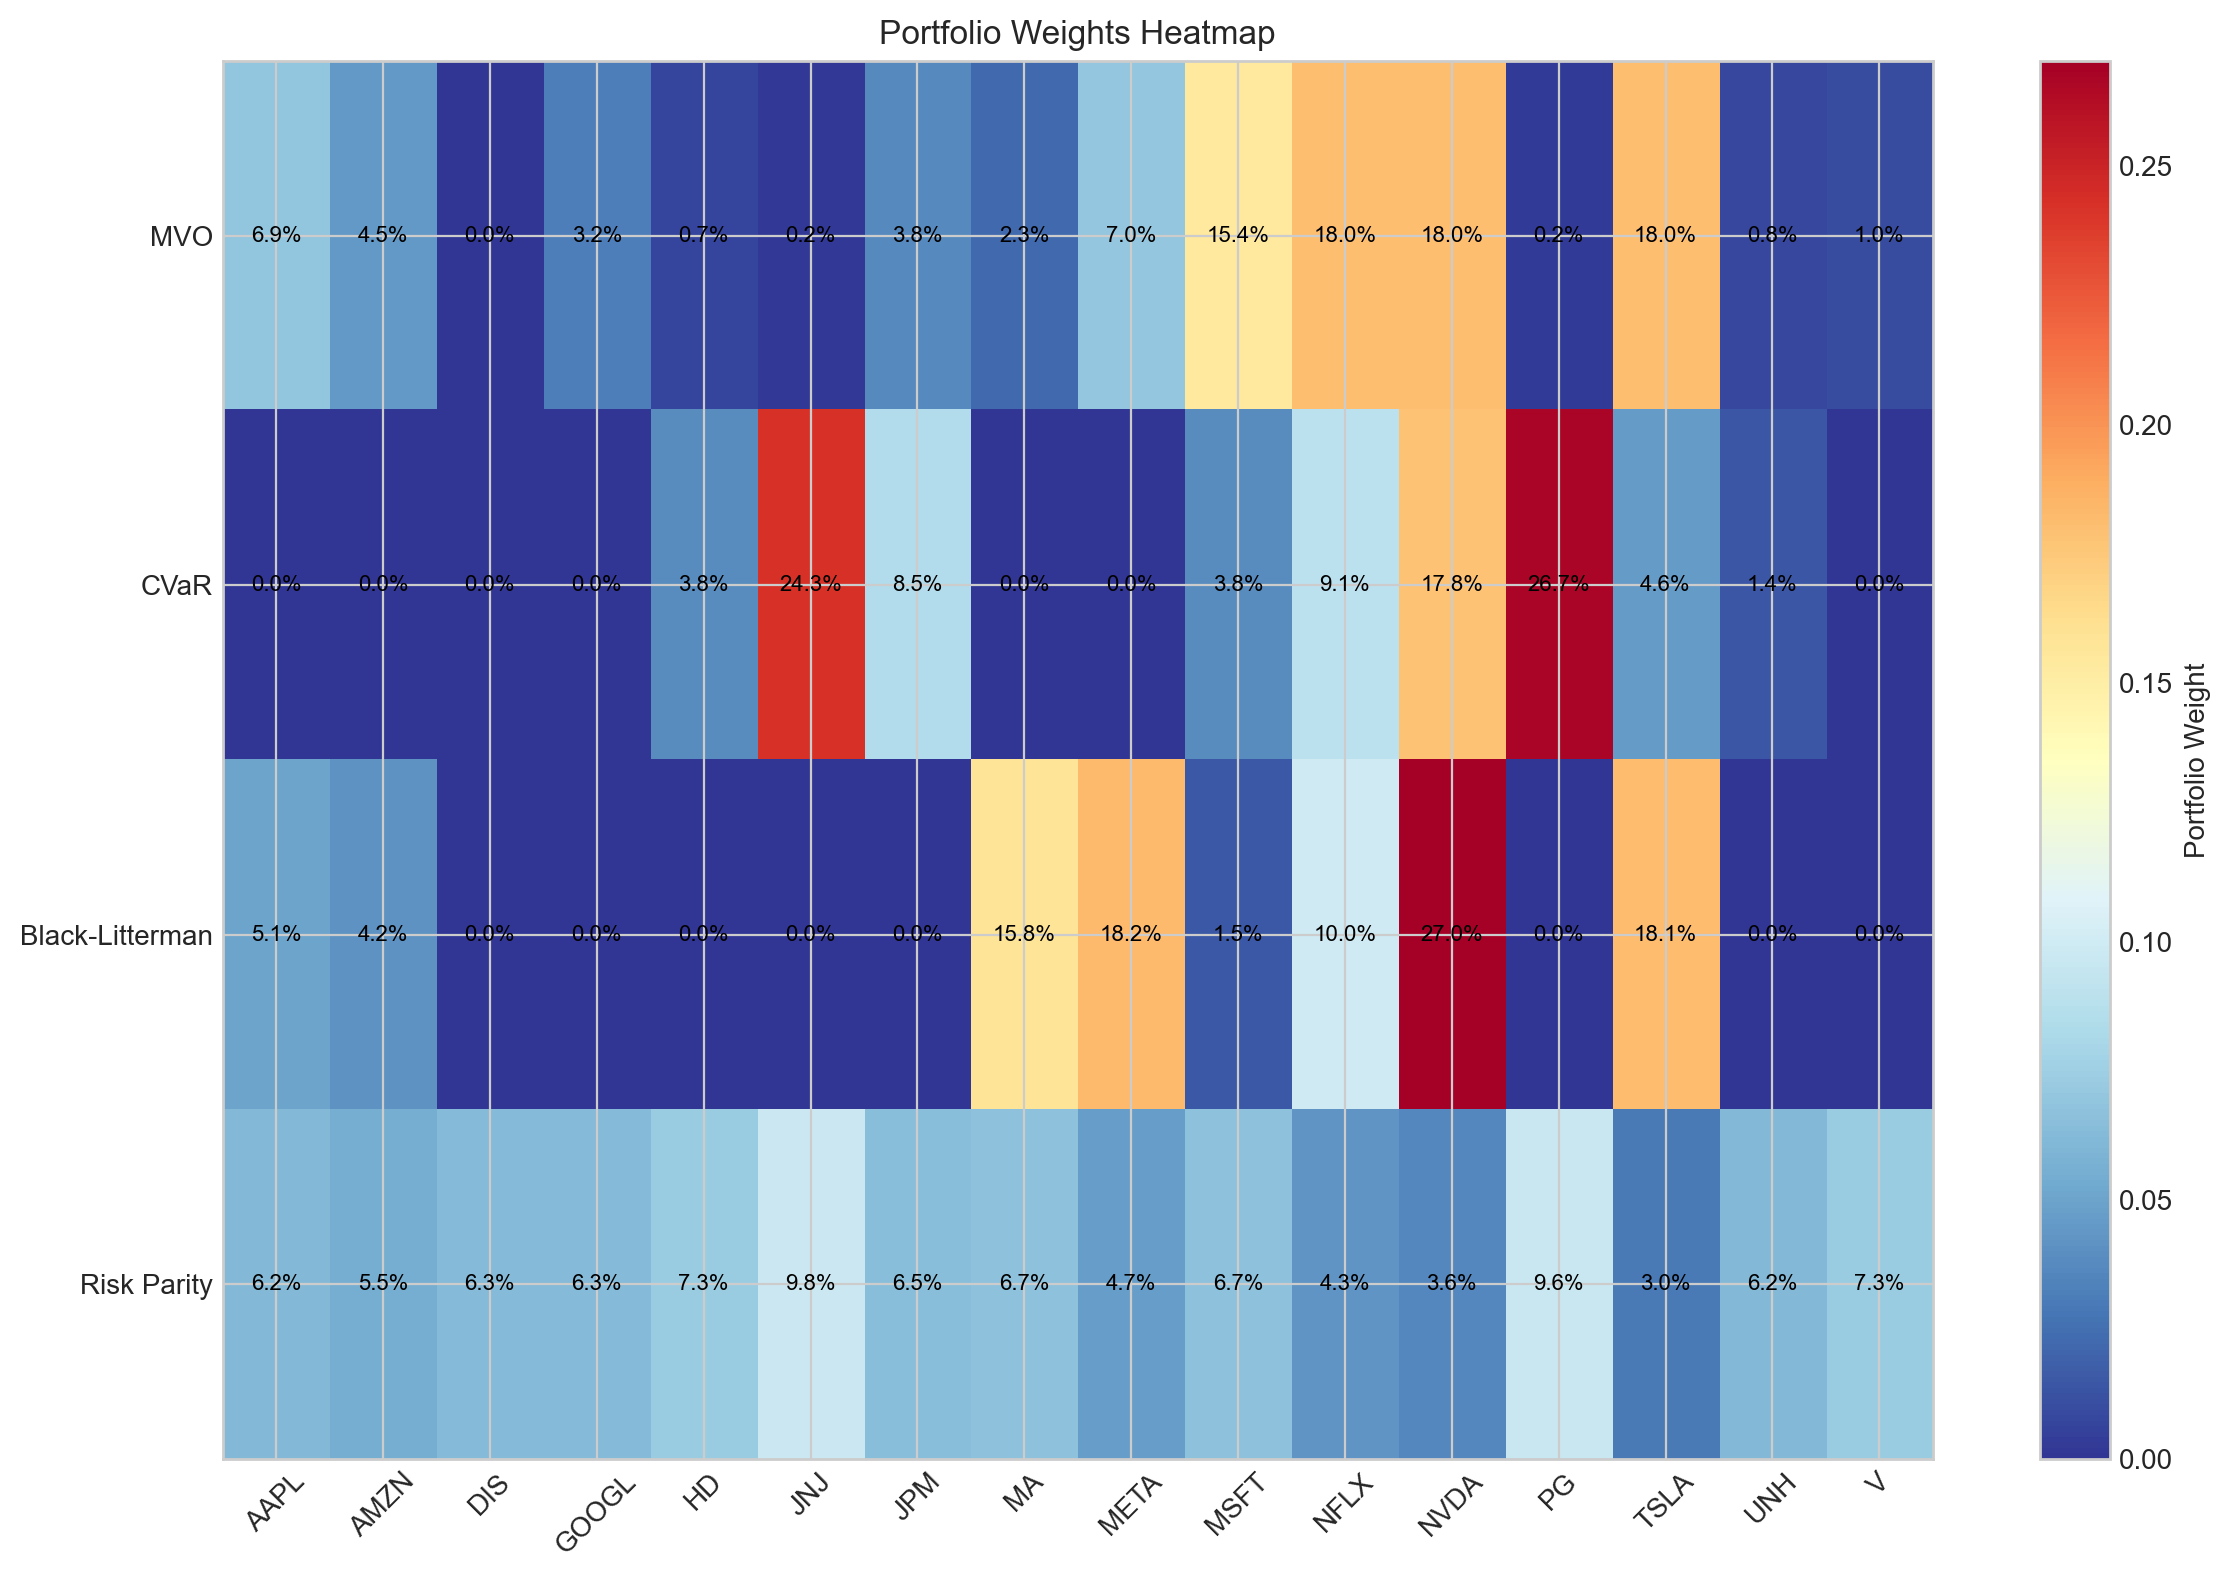

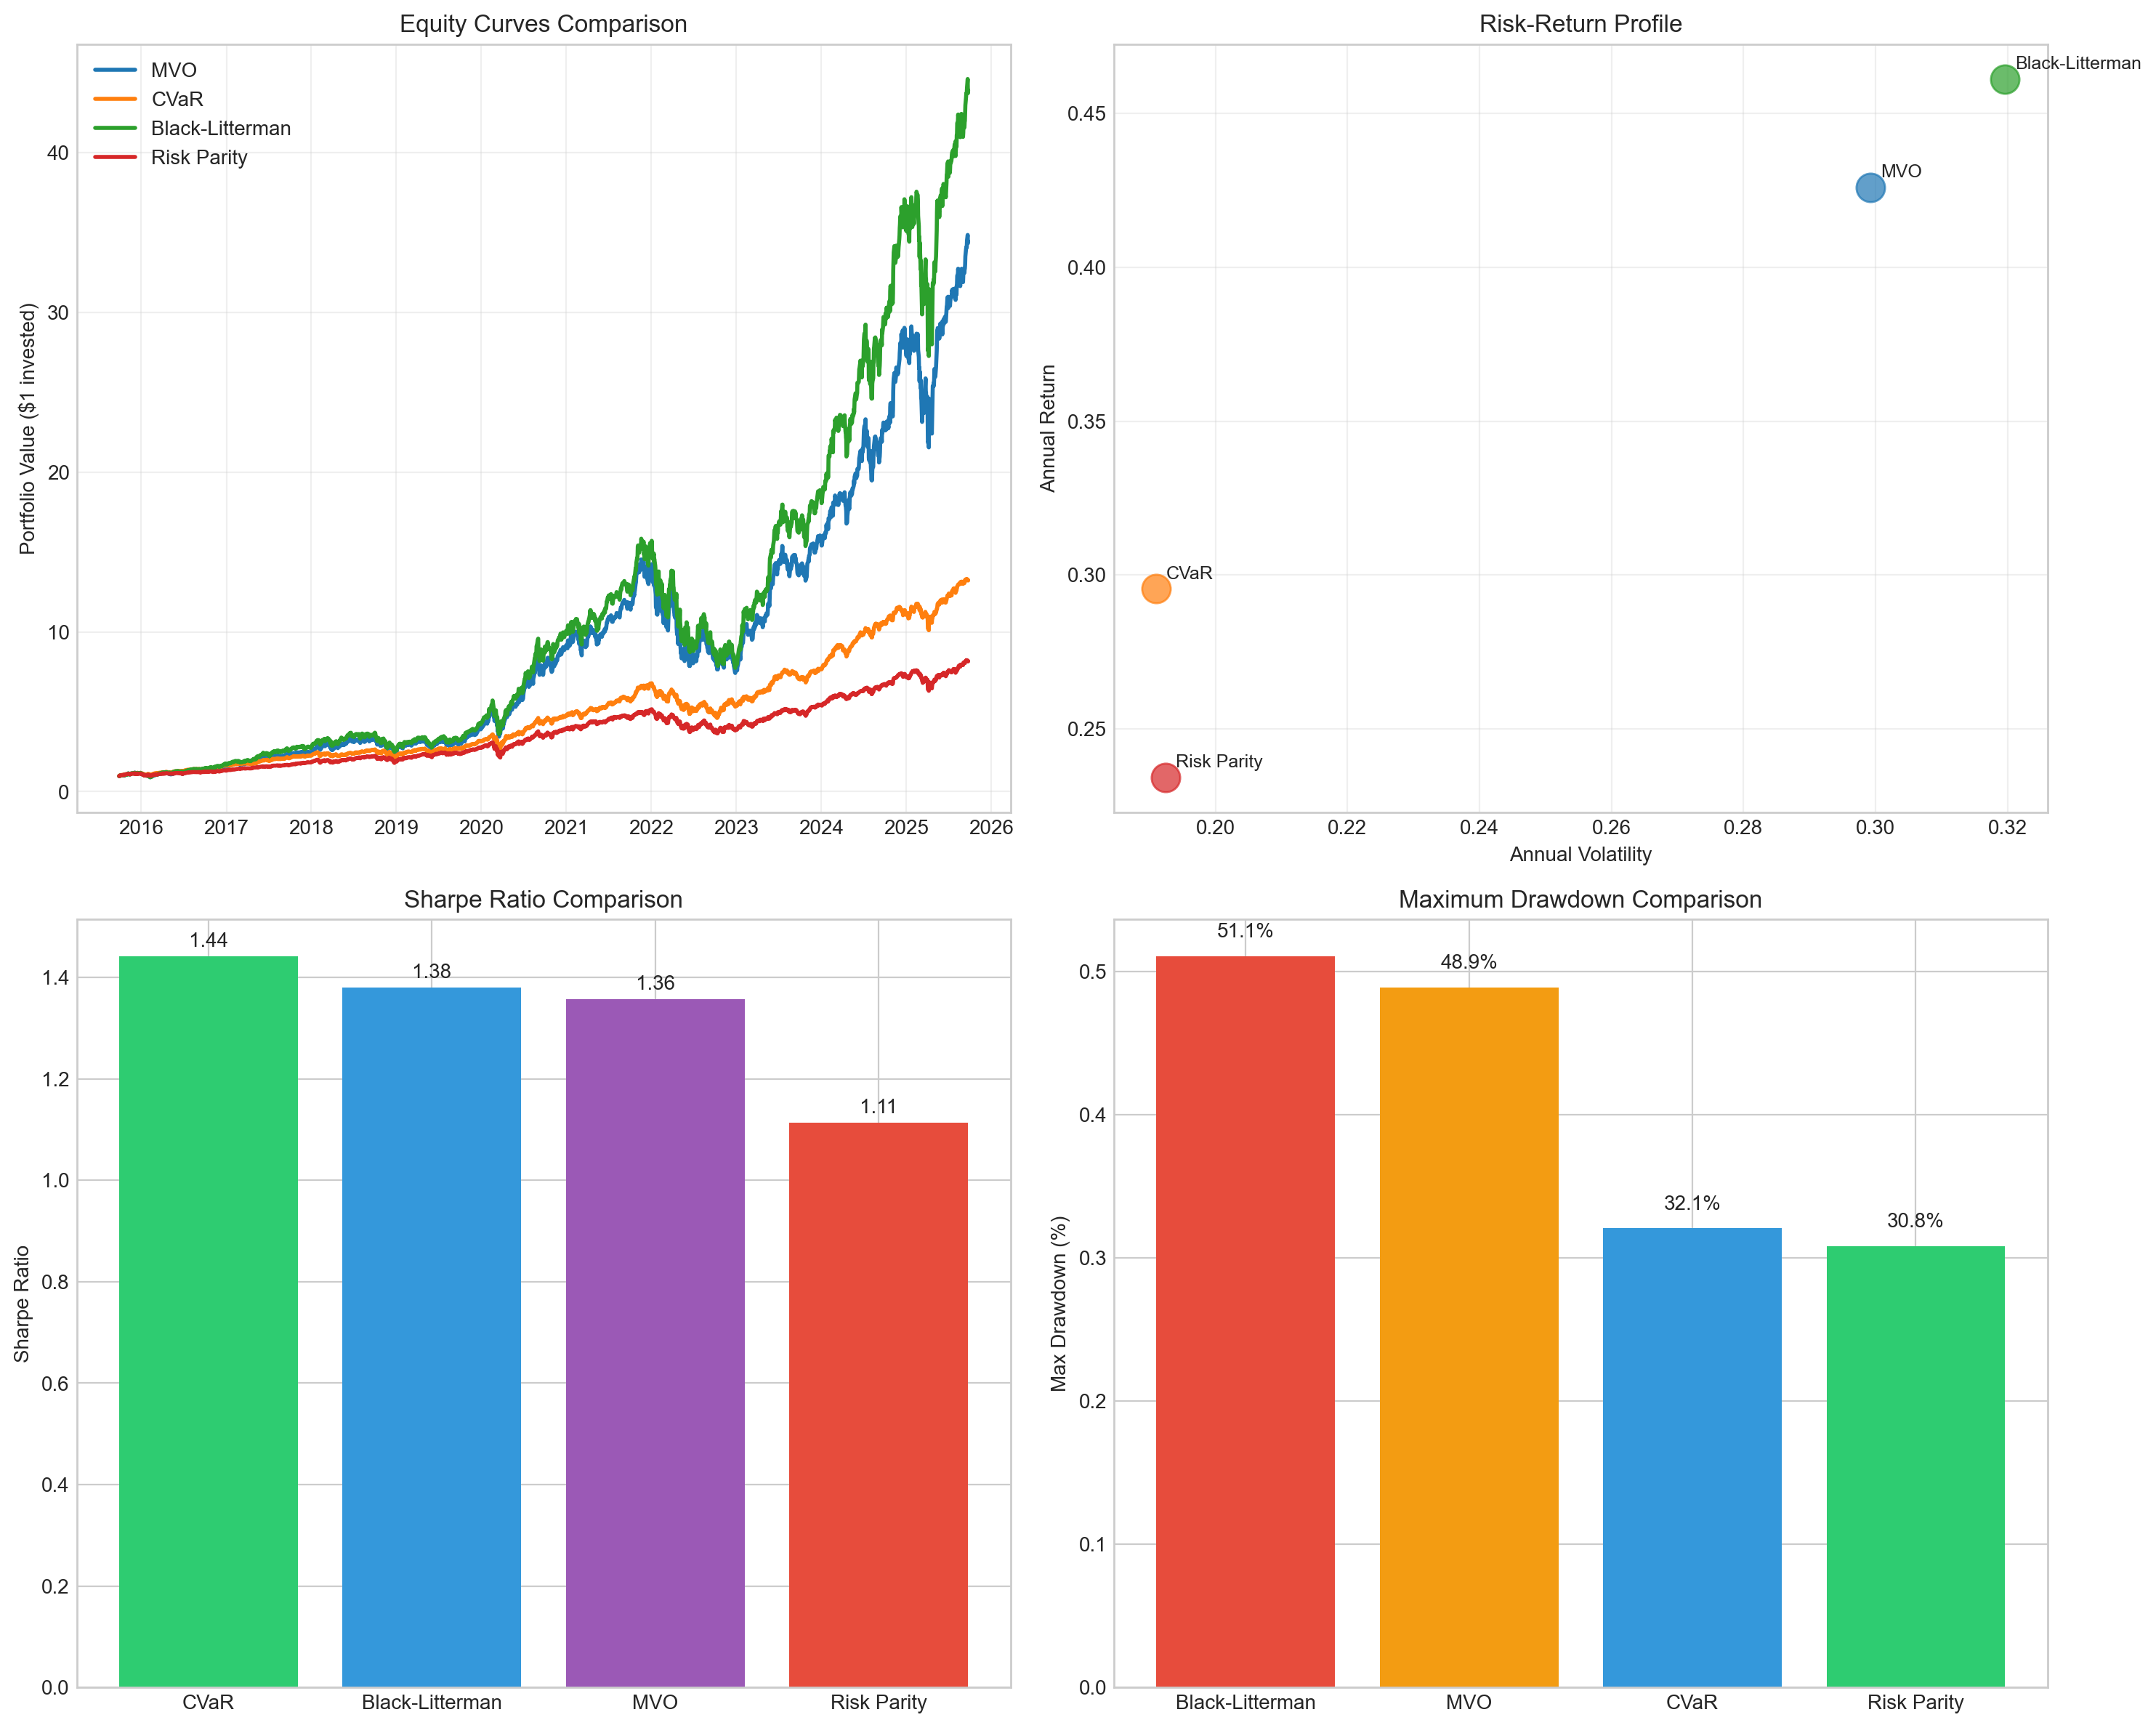

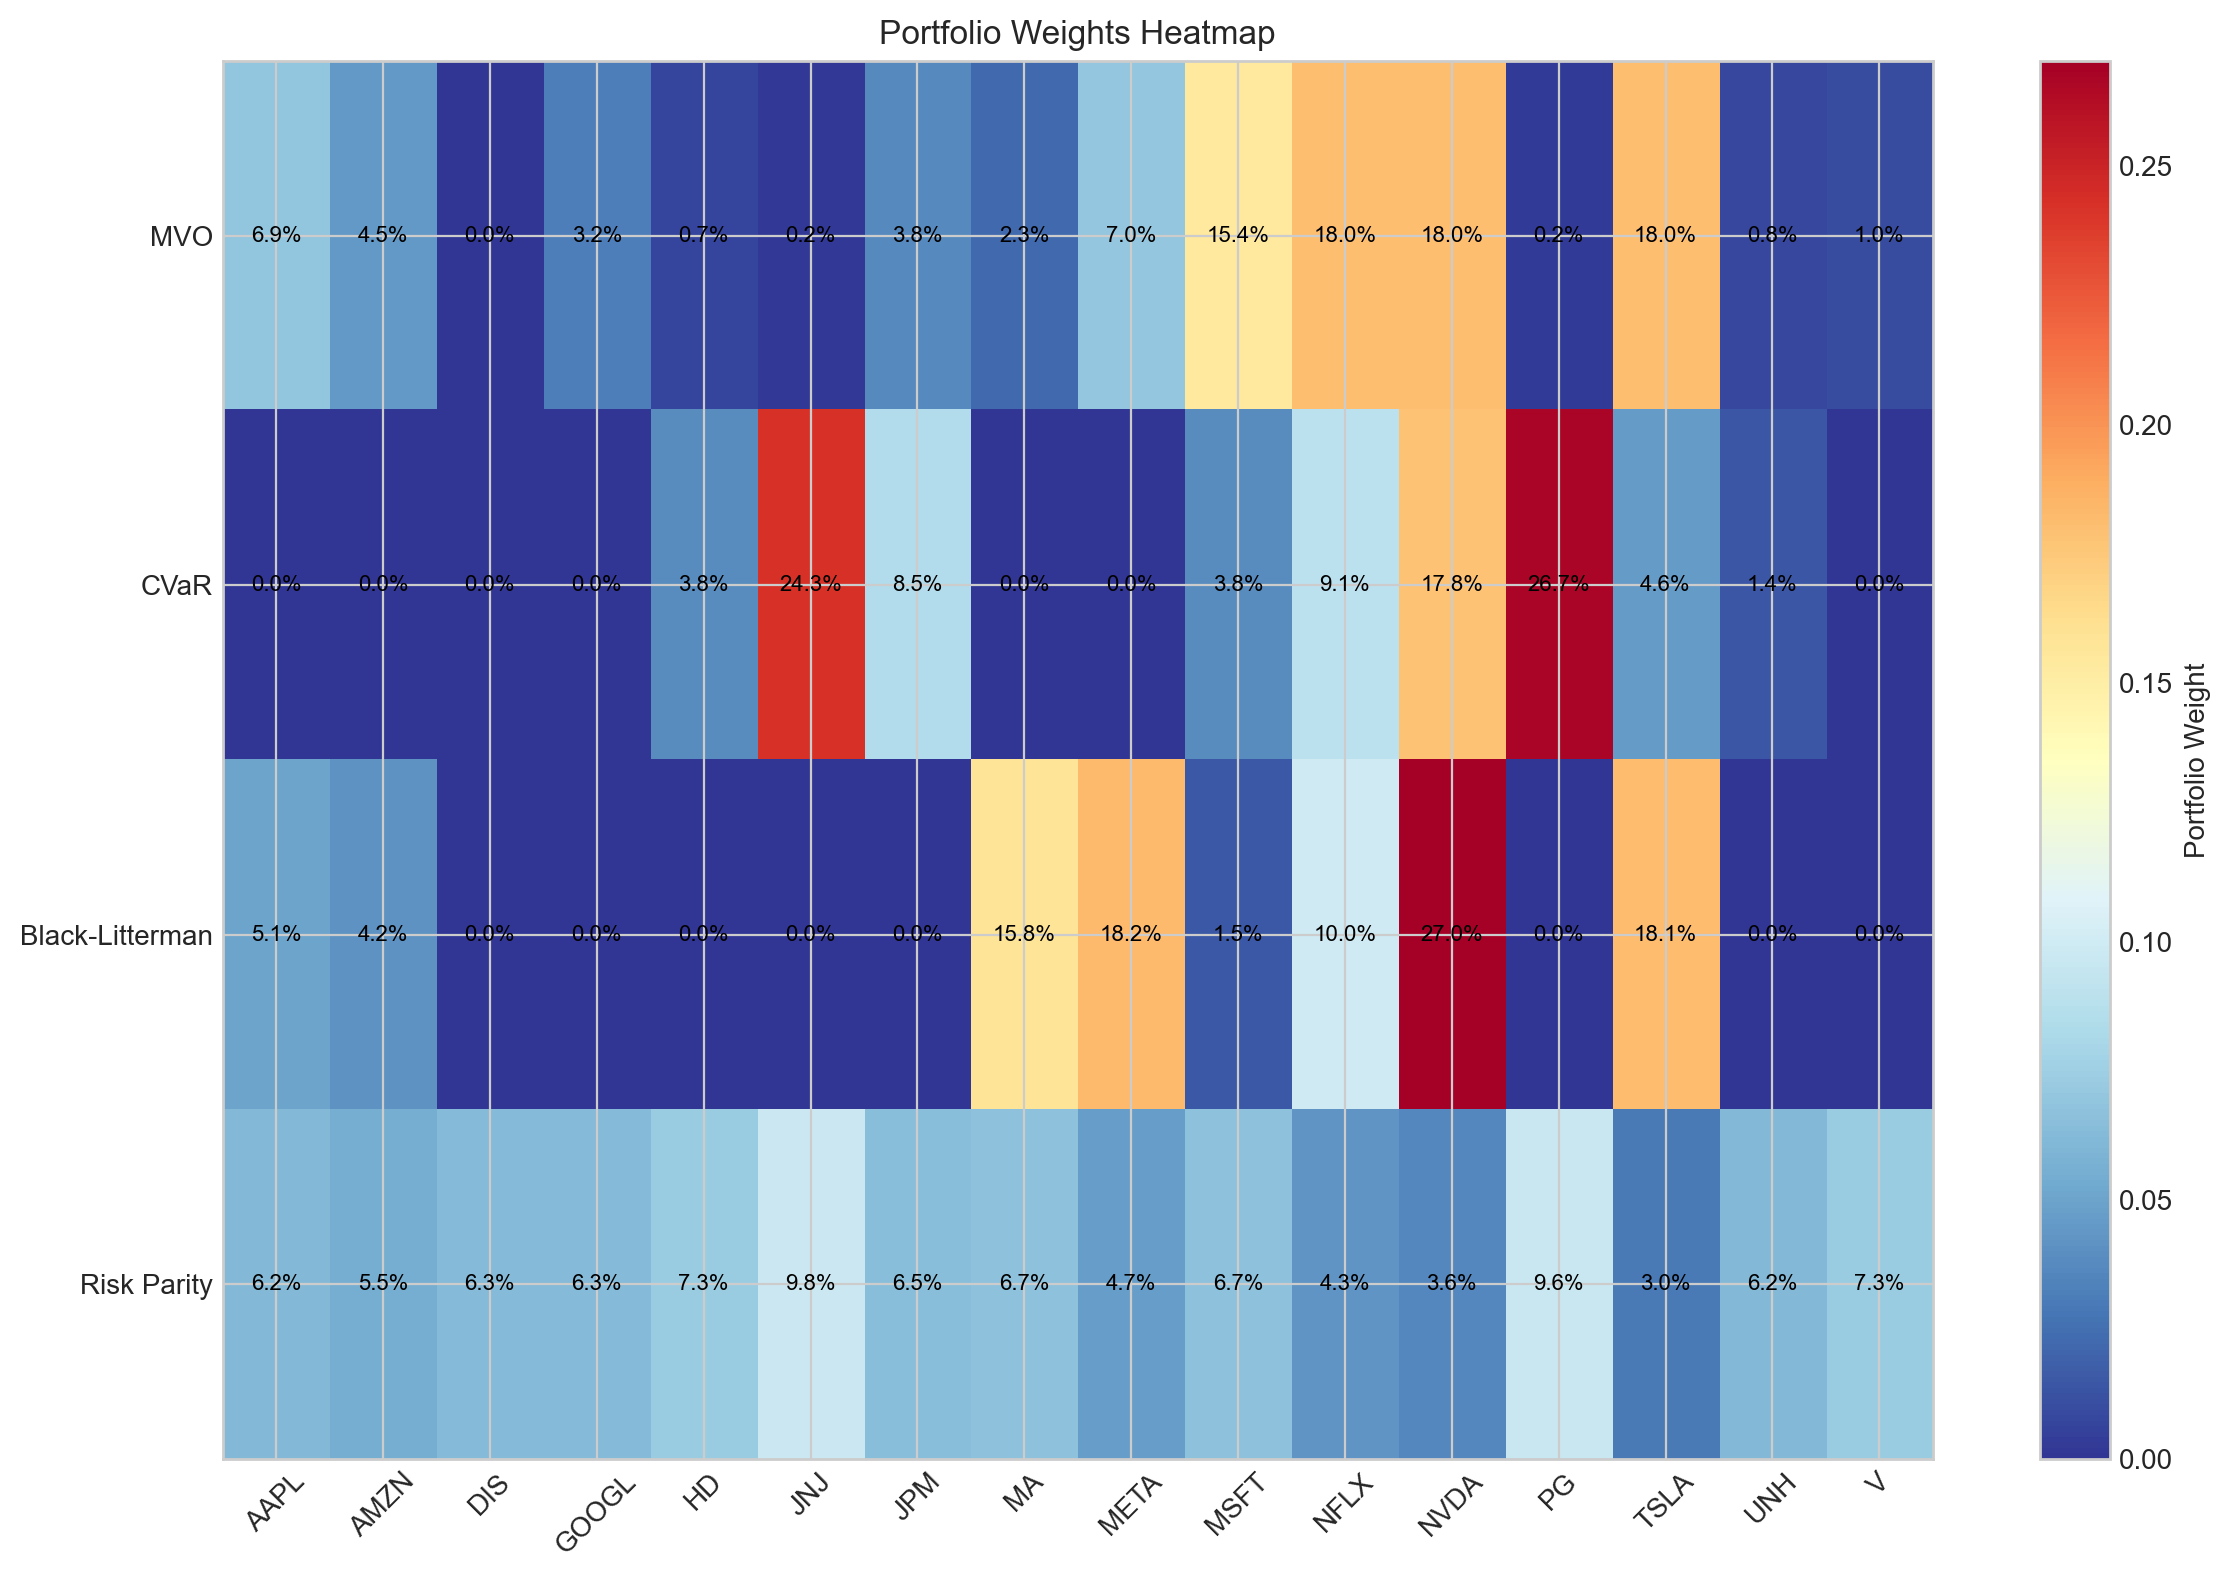

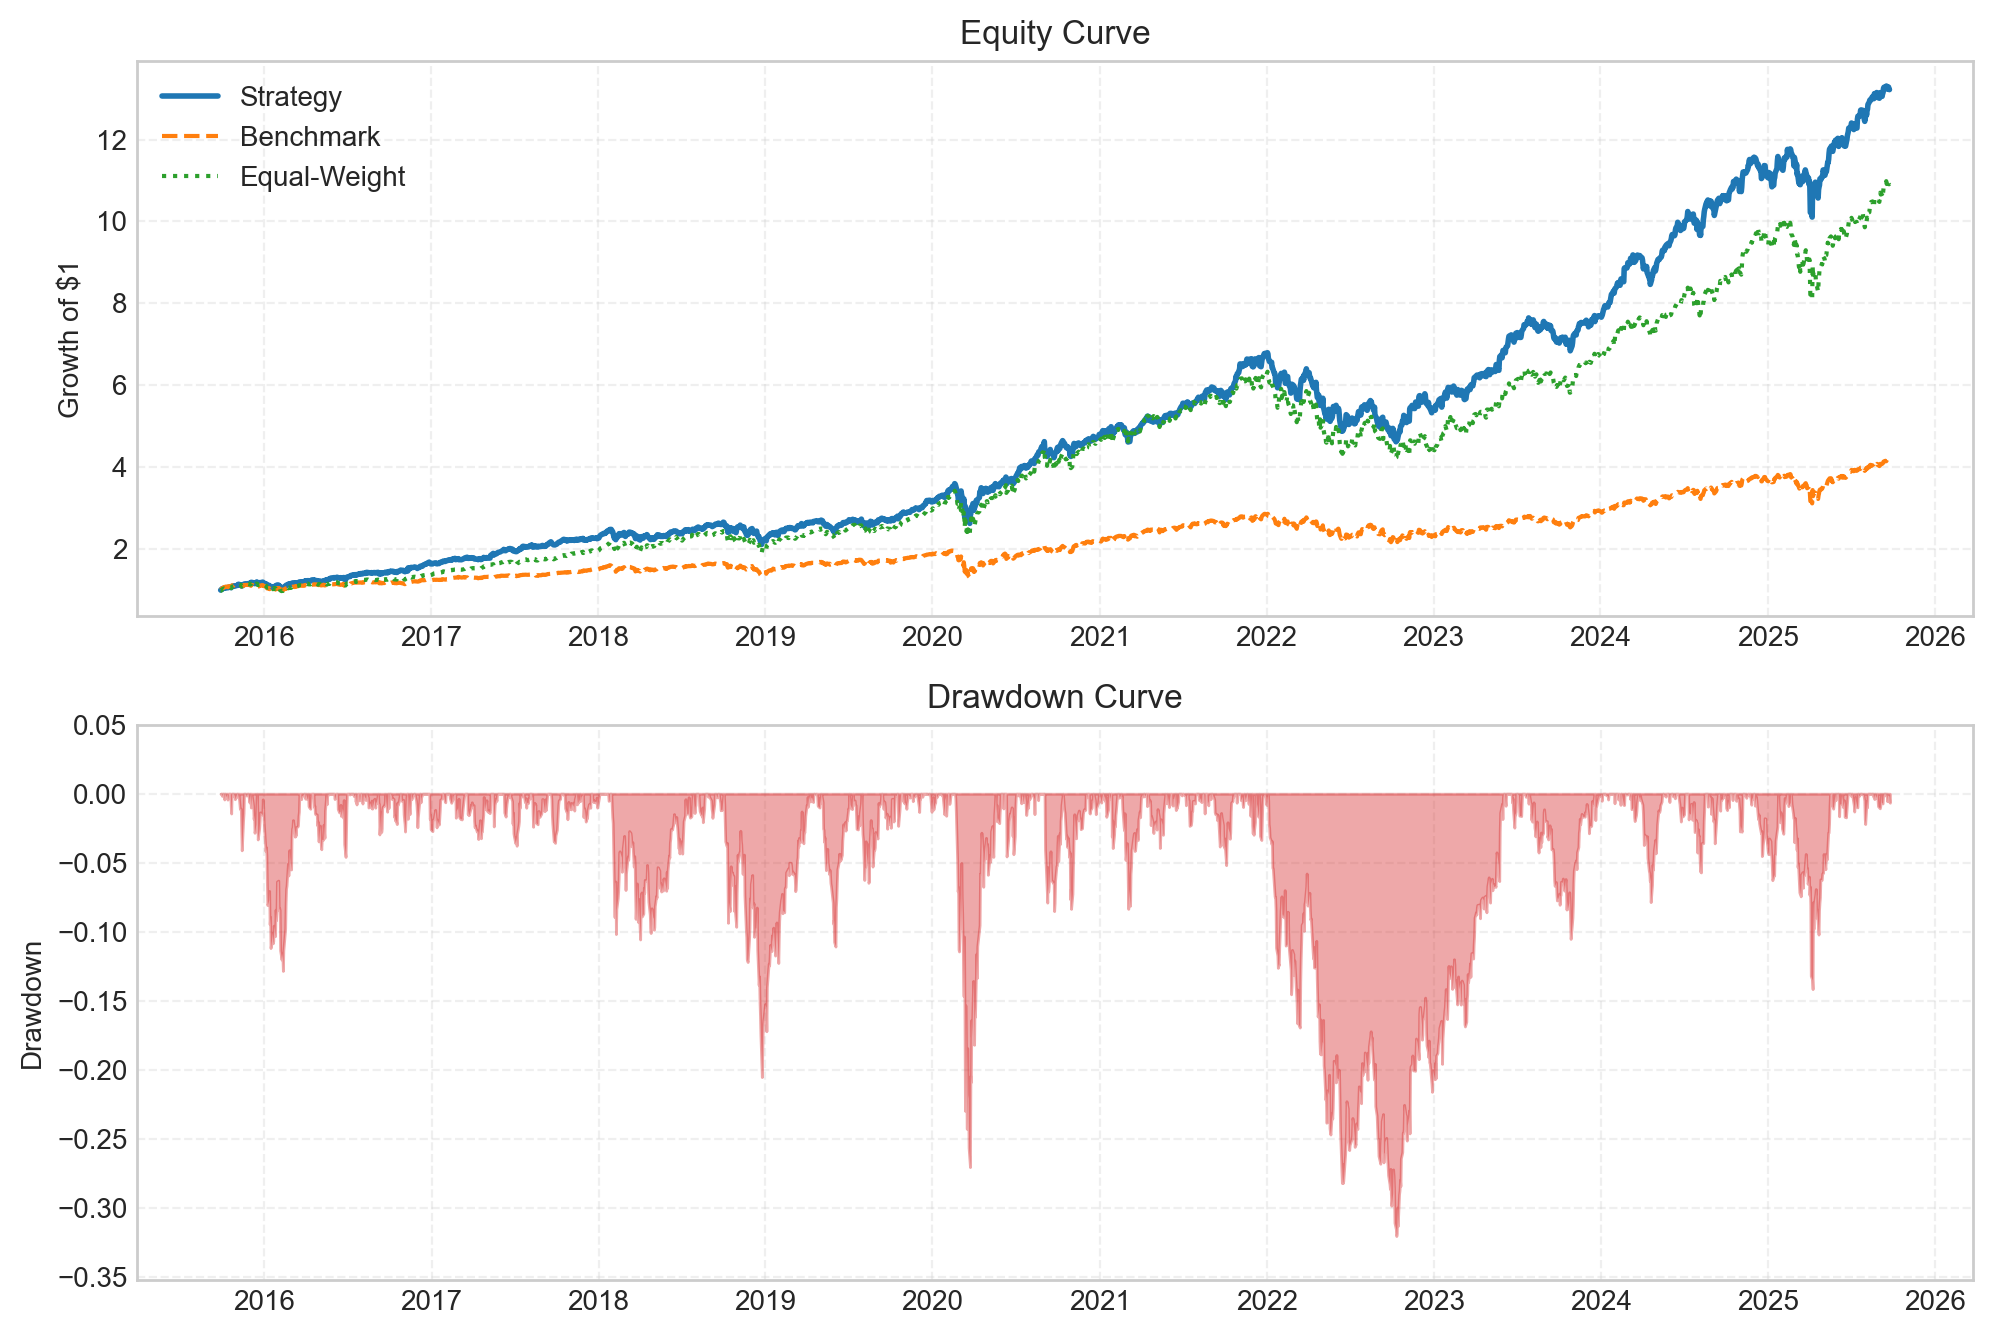

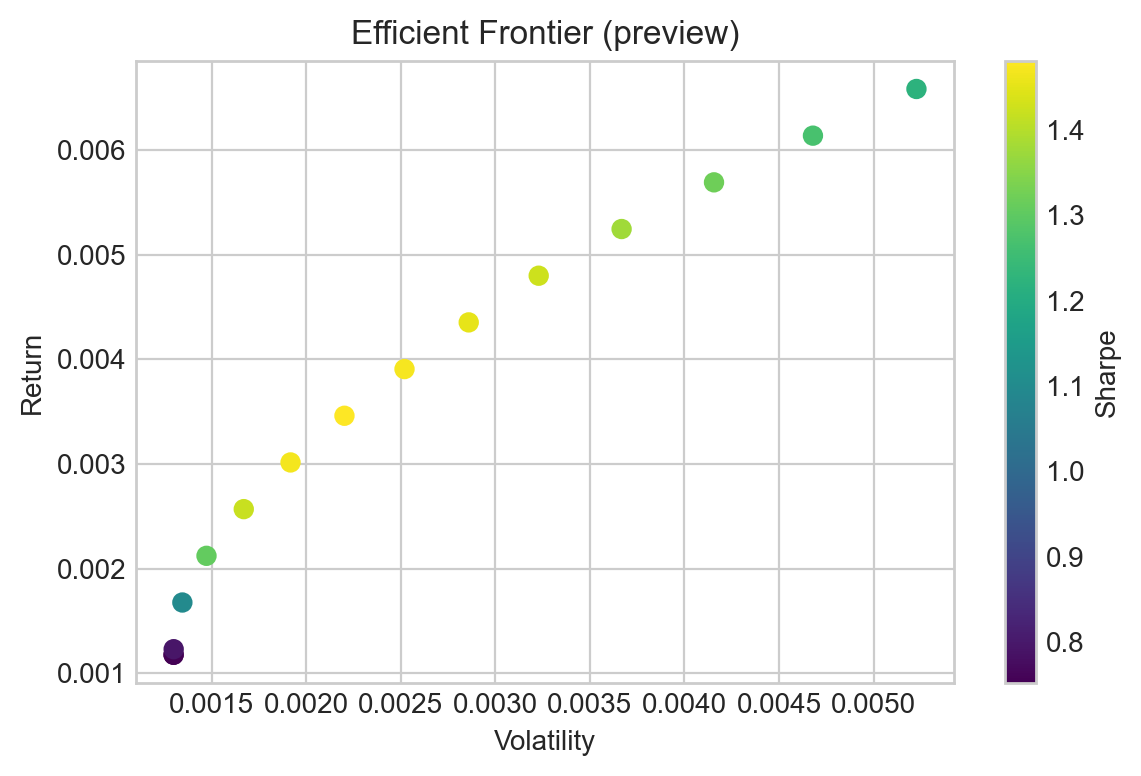

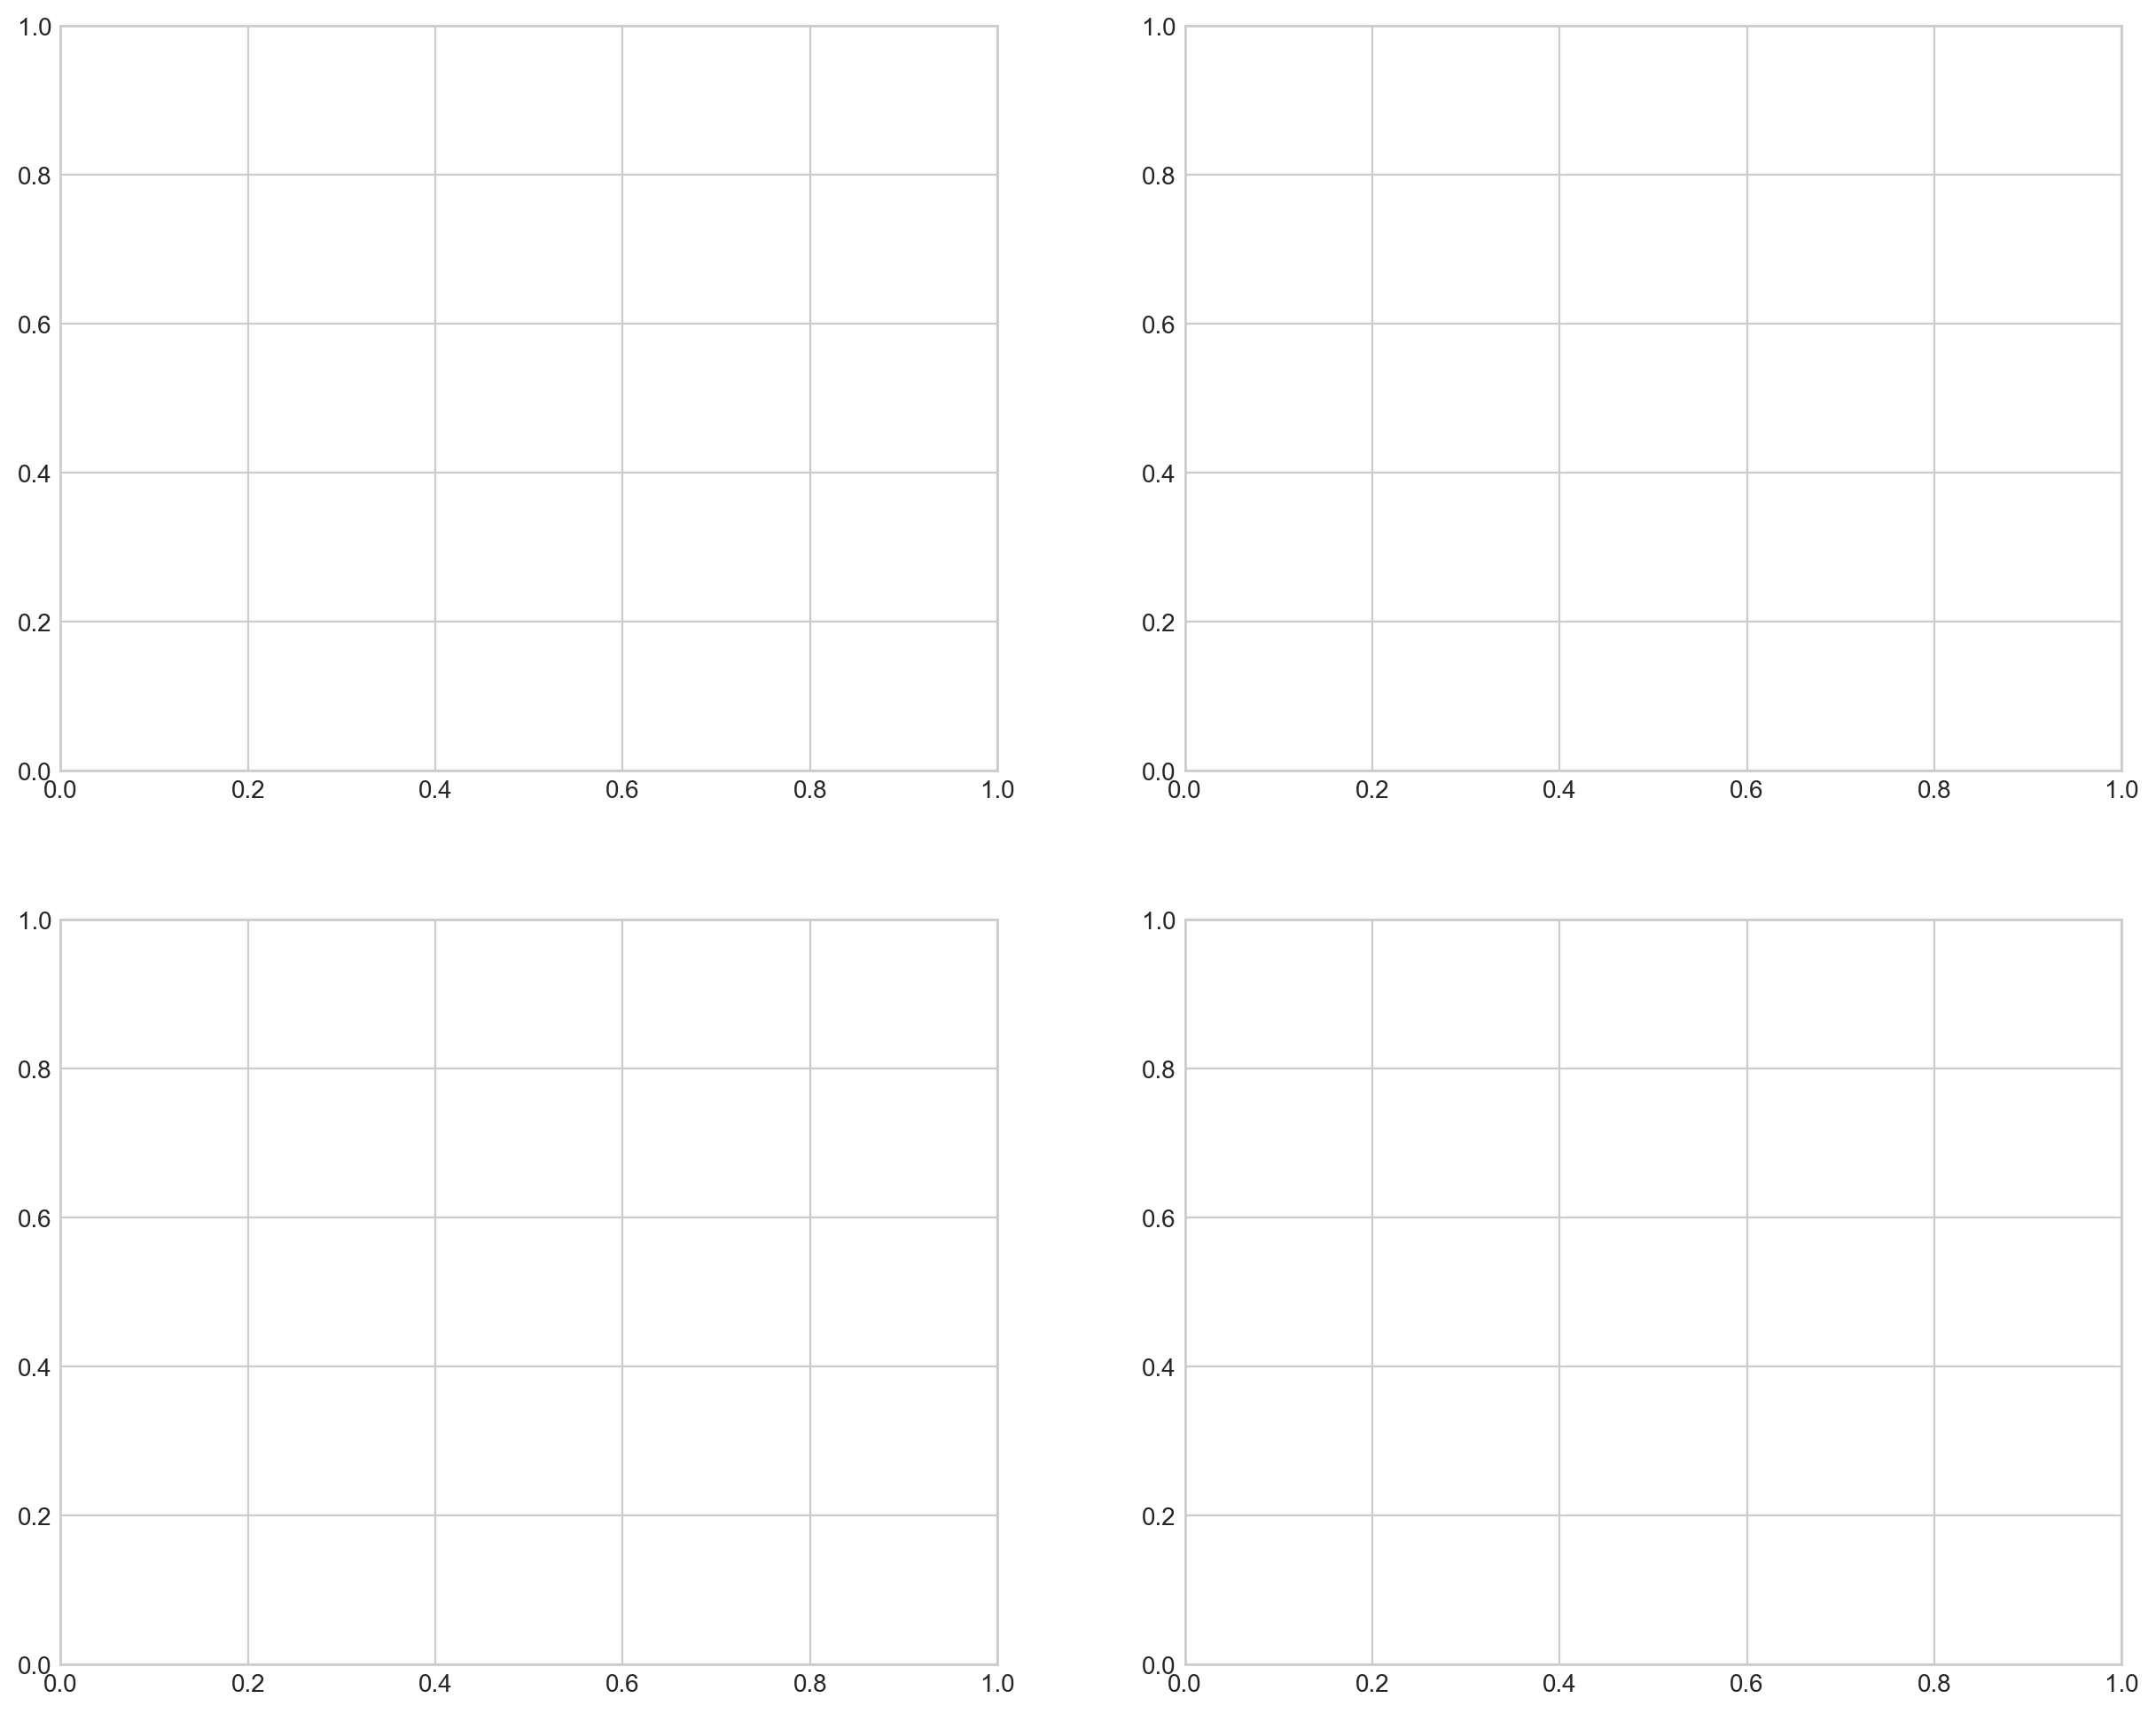

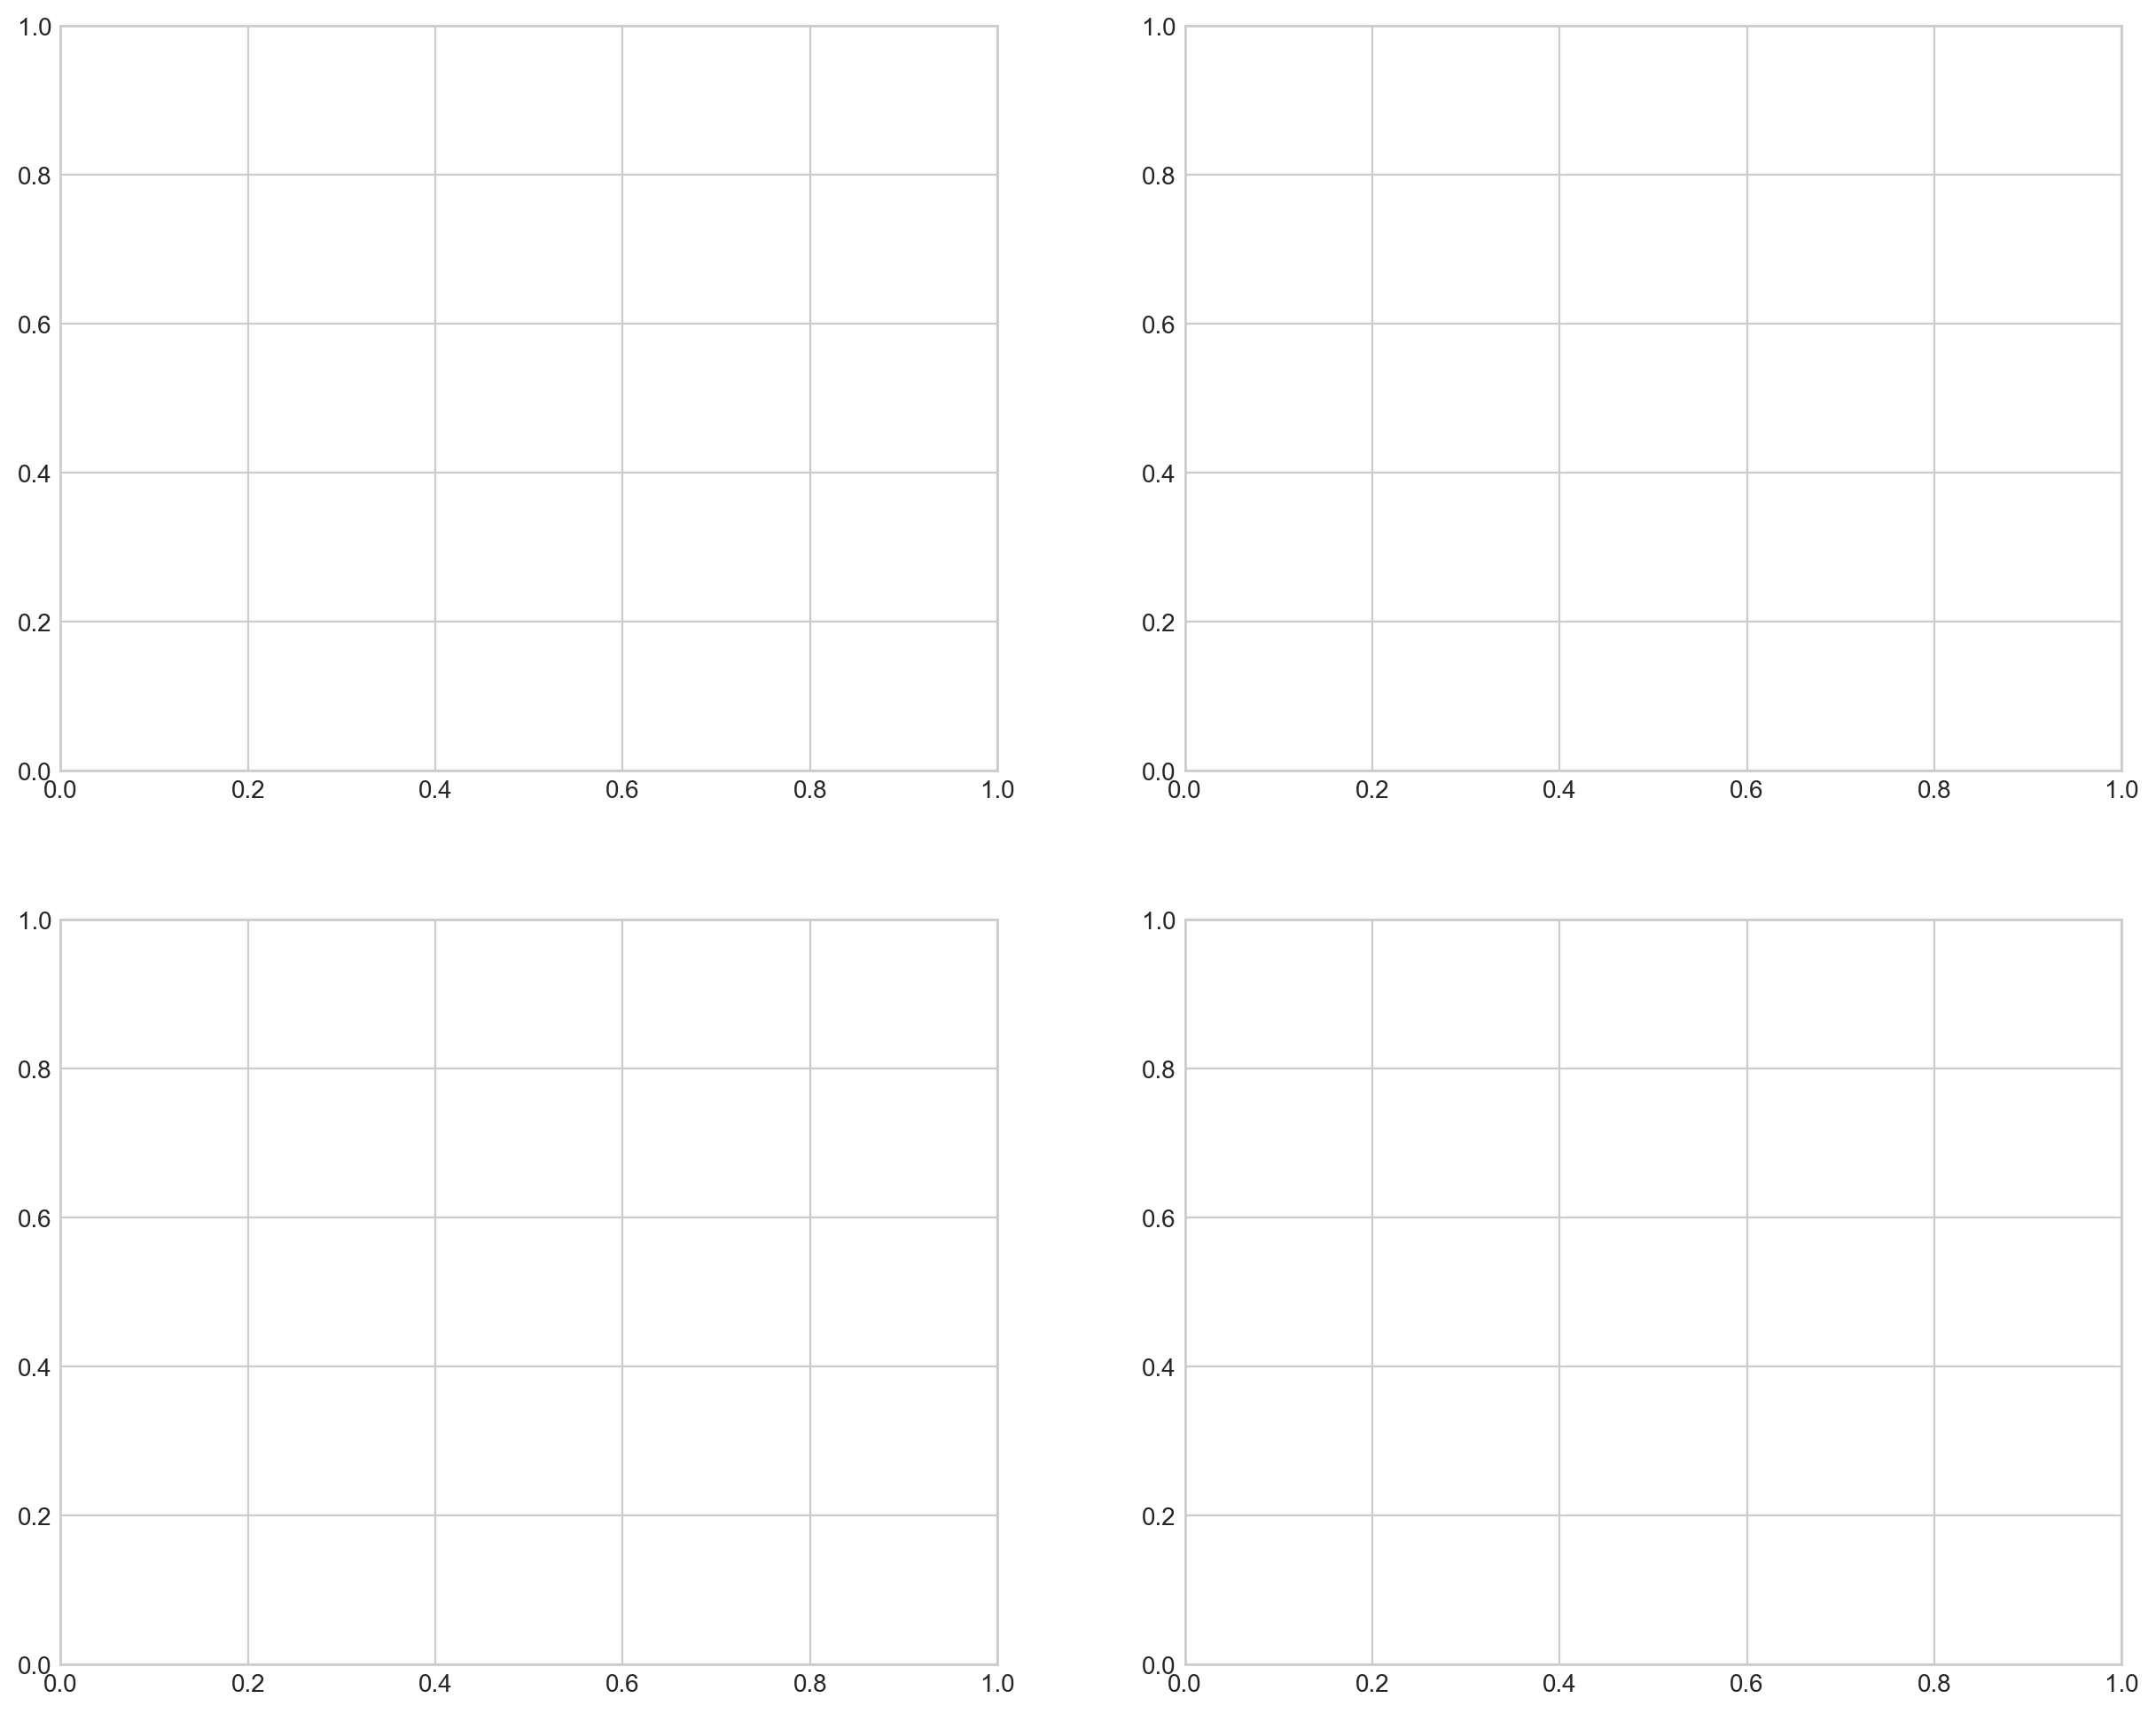

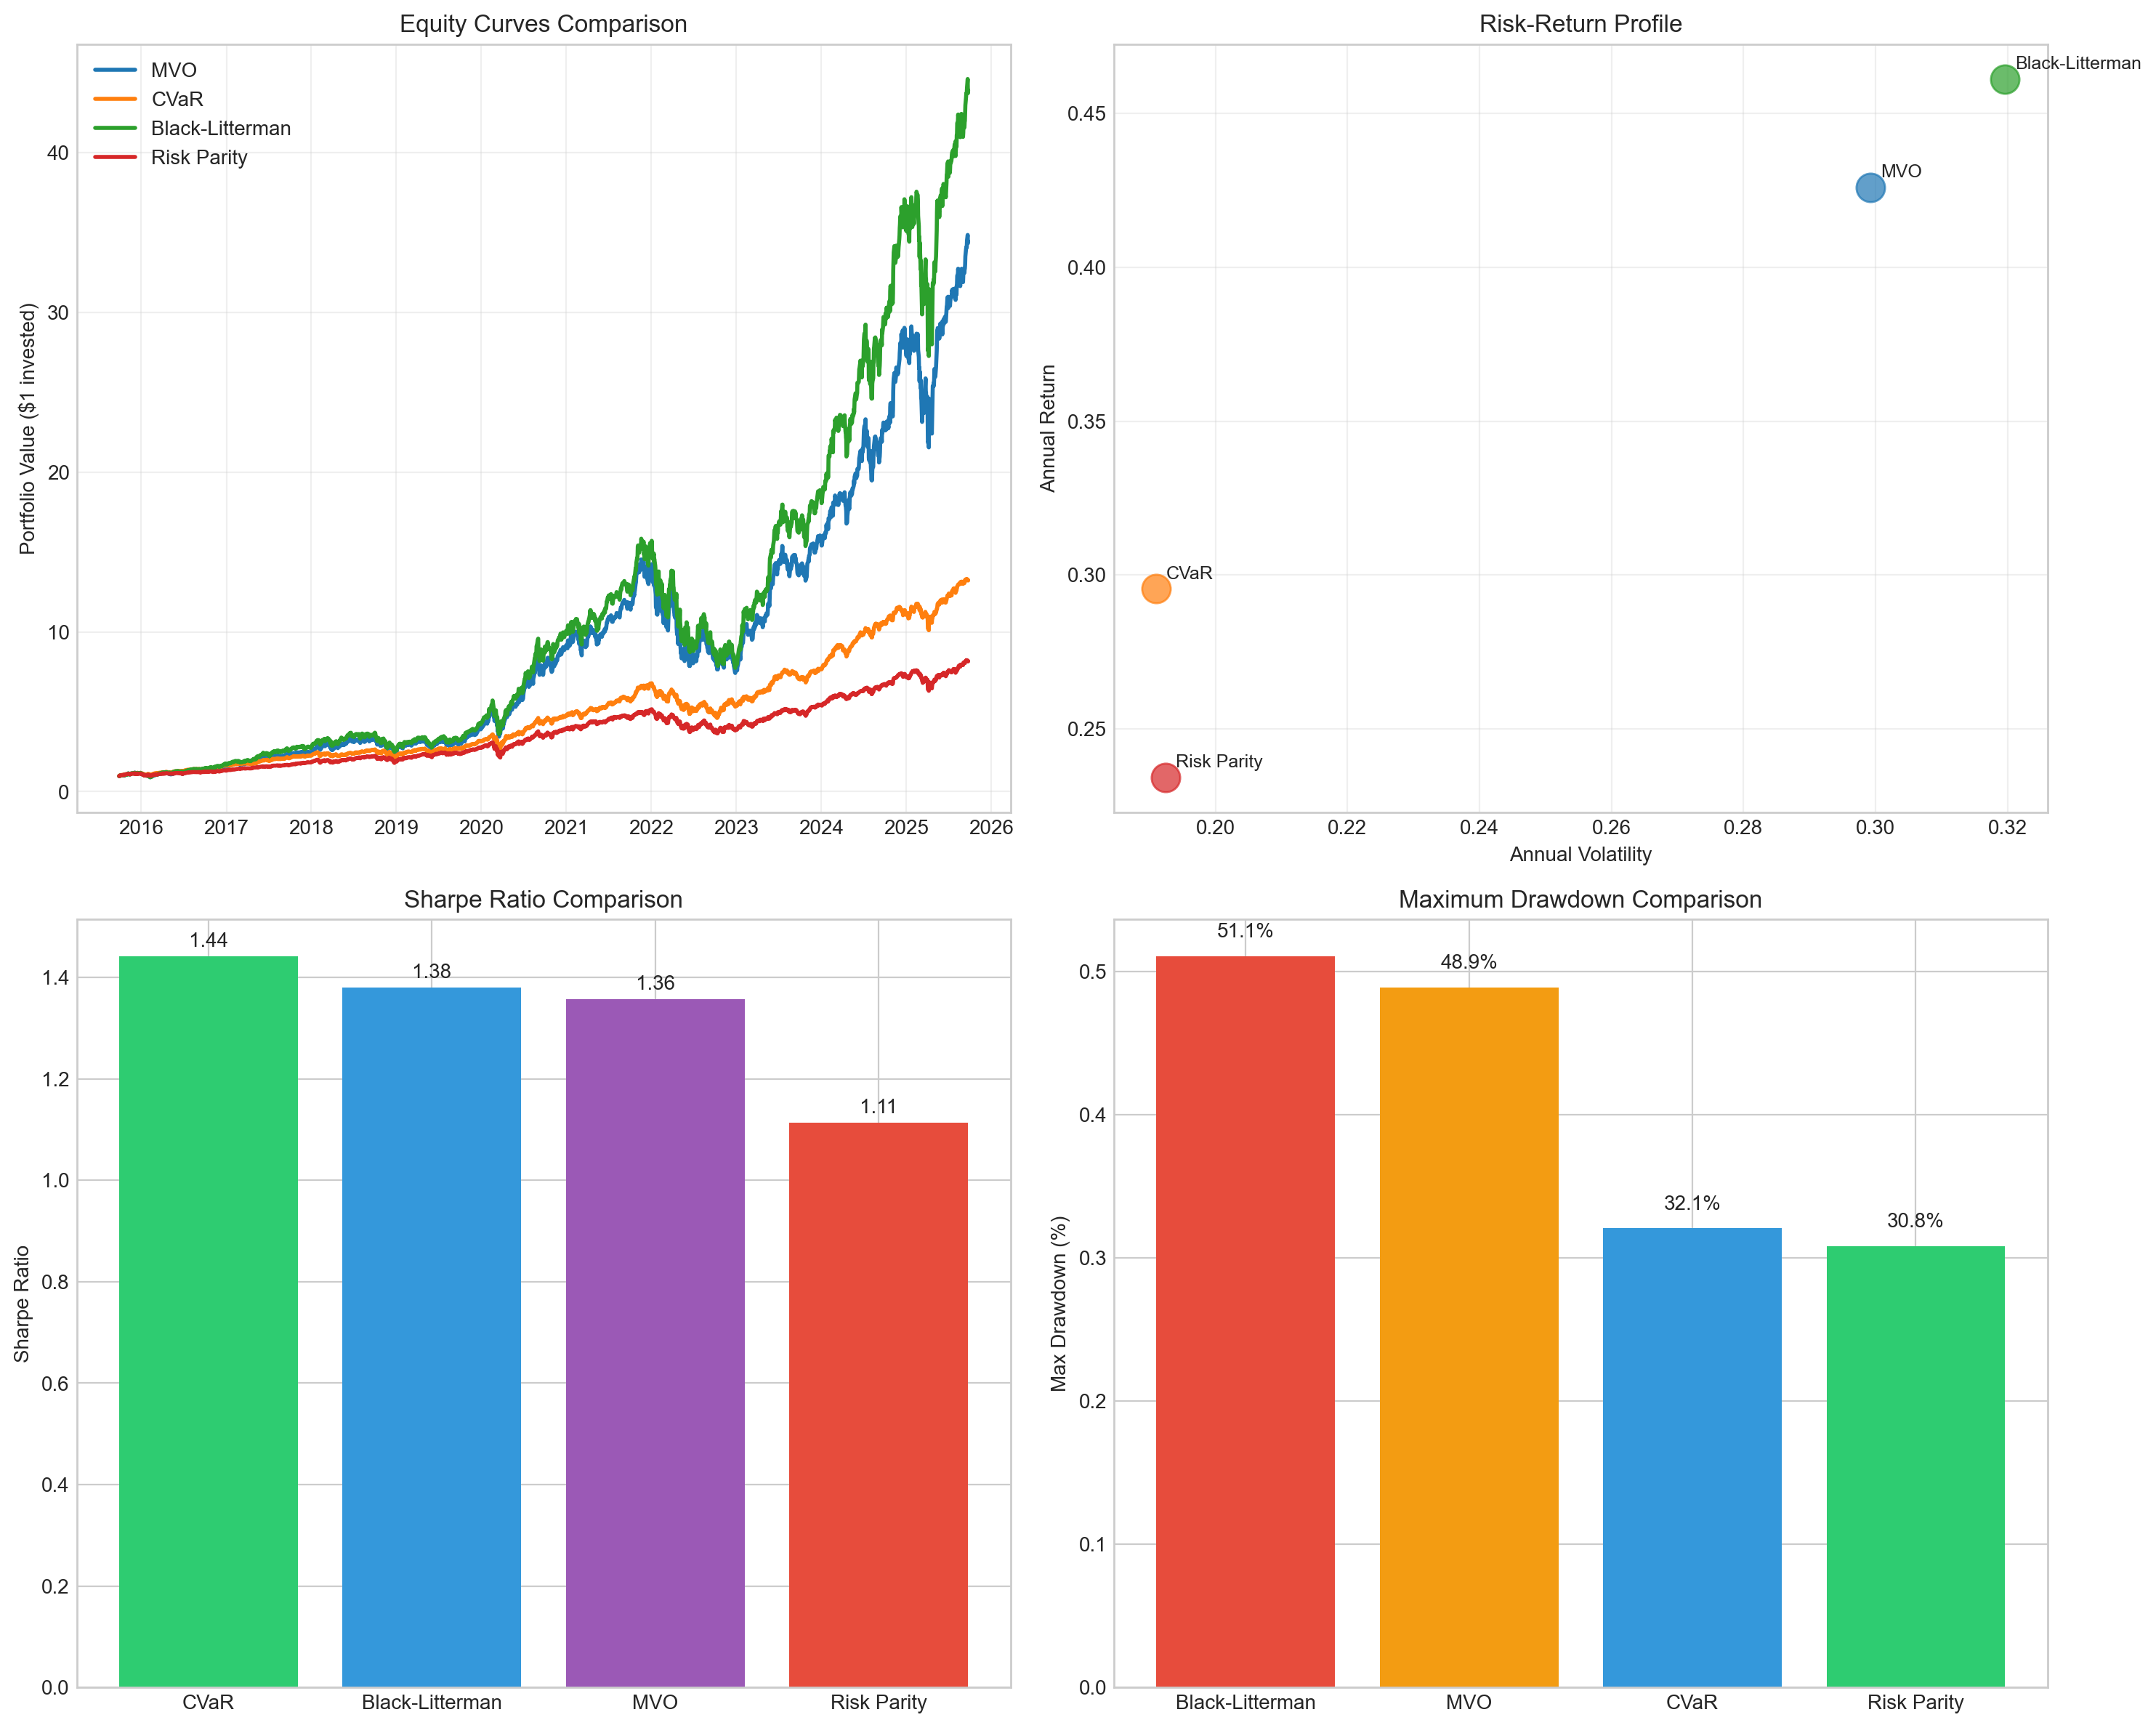

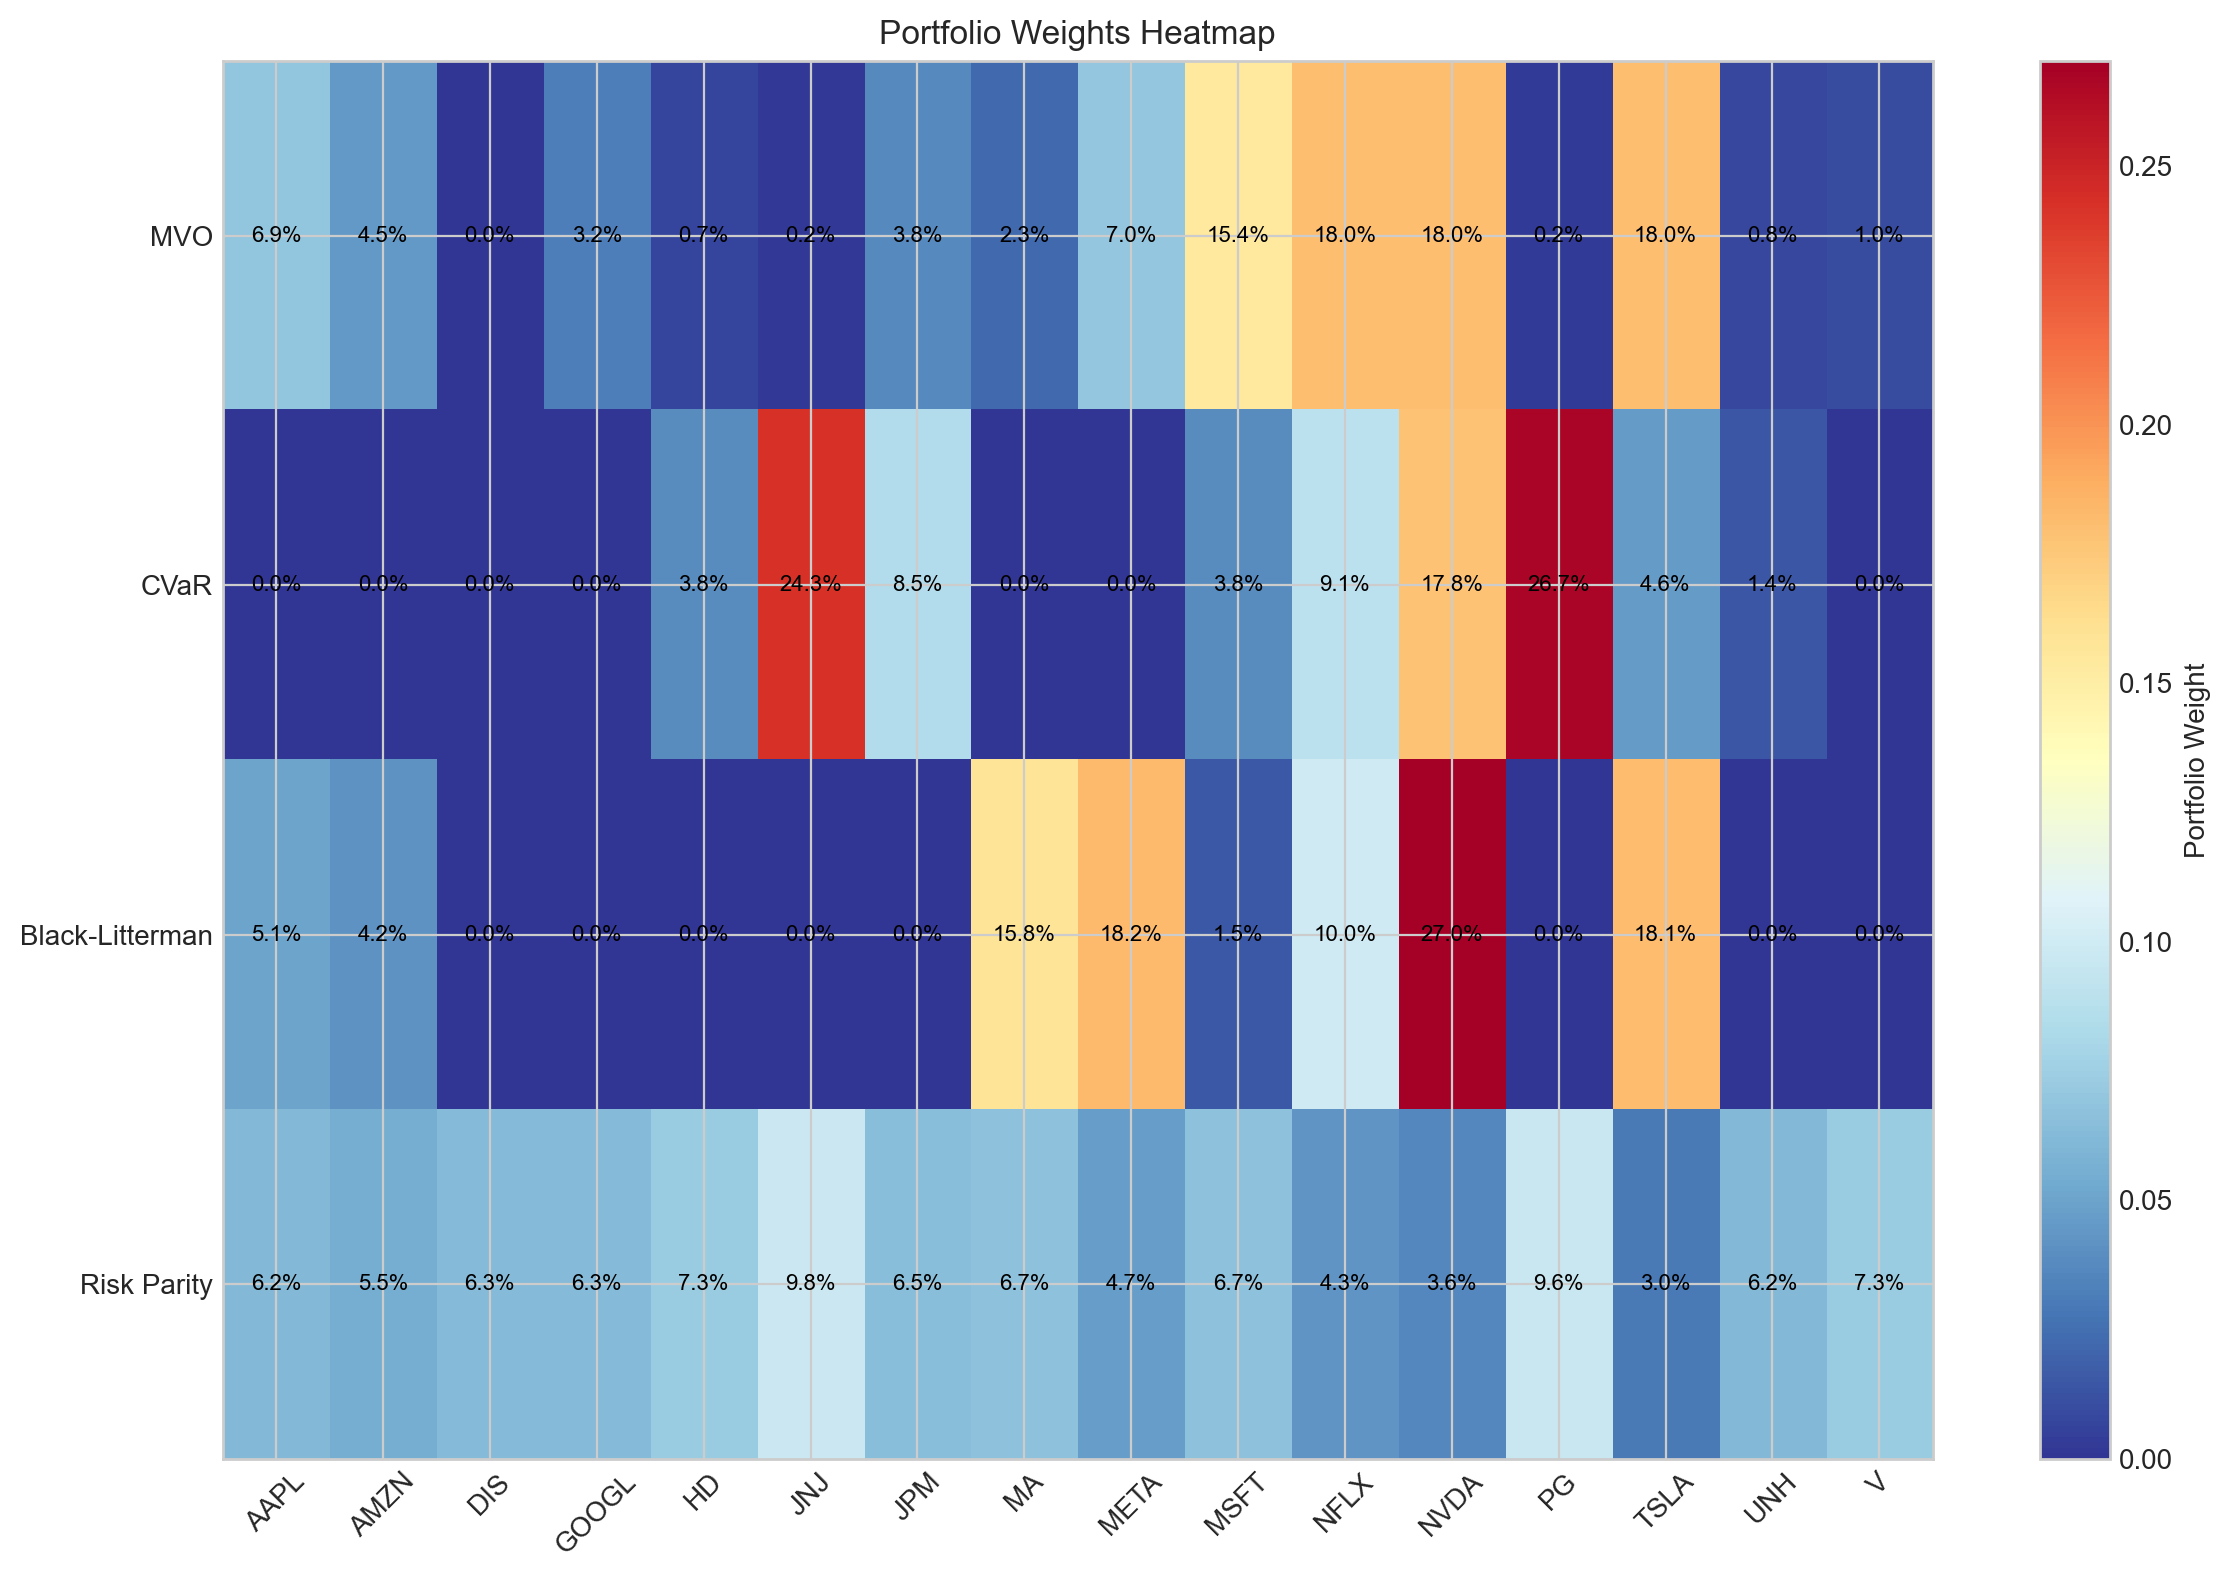

In [20]:
# Cell 5: Optimization Methods Visualization
# - Create comprehensive visualizations comparing all optimization methods
# - Plot equity curves to show growth over time
# - Risk-return scatter plot to visualize efficient frontier
# - Bar charts for Sharpe ratio and maximum drawdown comparison
# - Portfolio weights heatmap to show asset allocation across methods

# Optimization Methods Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Equity Curves Comparison
ax1 = axes[0, 0]
for method, data in results.items():
    equity_curve = (1 + data['returns']).cumprod()
    ax1.plot(equity_curve.index, equity_curve.values, label=method, linewidth=2)
ax1.set_title('Equity Curves Comparison')
ax1.set_ylabel('Portfolio Value ($1 invested)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Risk-Return Scatter Plot
ax2 = axes[0, 1]
for method, data in results.items():
    metrics = data['metrics']
    ax2.scatter(metrics['annual_volatility'], metrics['annual_return'], 
               s=200, label=method, alpha=0.7)
    ax2.annotate(method, (metrics['annual_volatility'], metrics['annual_return']), 
                xytext=(5, 5), textcoords='offset points', fontsize=9)
ax2.set_xlabel('Annual Volatility')
ax2.set_ylabel('Annual Return')
ax2.set_title('Risk-Return Profile')
ax2.grid(True, alpha=0.3)

# 3. Sharpe Ratio Comparison
ax3 = axes[1, 0]
sharpe_data = [(method, data['metrics']['sharpe_ratio']) for method, data in results.items()]
sharpe_data.sort(key=lambda x: x[1], reverse=True)
methods, sharpe_values = zip(*sharpe_data)
bars = ax3.bar(methods, sharpe_values, color=['#2ecc71', '#3498db', '#9b59b6', '#e74c3c'])
ax3.set_title('Sharpe Ratio Comparison')
ax3.set_ylabel('Sharpe Ratio')
for bar, value in zip(bars, sharpe_values):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.2f}', ha='center', va='bottom')

# 4. Max Drawdown Comparison
ax4 = axes[1, 1]
drawdown_data = [(method, data['metrics']['max_drawdown']) for method, data in results.items()]
drawdown_data.sort(key=lambda x: x[1])  # Lower drawdown is better
methods, drawdown_values = zip(*drawdown_data)
bars = ax4.bar(methods, [abs(d) for d in drawdown_values], 
               color=['#e74c3c', '#f39c12', '#3498db', '#2ecc71'])
ax4.set_title('Maximum Drawdown Comparison')
ax4.set_ylabel('Max Drawdown (%)')
for bar, value in zip(bars, drawdown_values):
    ax4.text(bar.get_x() + bar.get_width()/2, abs(value) + 0.01, 
             f'{abs(value):.1%}', ha='center', va='bottom')

plt.tight_layout()

# Handle display gracefully for non-interactive environments
from IPython.display import display
try:
    display(fig)
except Exception:
    # Silently handle the case where display is not available
    pass

# Additional analysis: Portfolio weights heatmap
fig, ax = plt.subplots(figsize=(12, 8))

# Create weights matrix for heatmap
weights_matrix = []
methods_list = []
assets_list = []

for method, data in results.items():
    weights = data['weights'].sort_index()
    weights_matrix.append(weights.values)
    methods_list.append(method)

if weights_matrix:
    weights_matrix = np.array(weights_matrix)
    assets_list = sorted(results['MVO']['weights'].index)
    
    im = ax.imshow(weights_matrix, cmap='RdYlBu_r', aspect='auto')
    ax.set_xticks(range(len(assets_list)))
    ax.set_yticks(range(len(methods_list)))
    ax.set_xticklabels(assets_list, rotation=45)
    ax.set_yticklabels(methods_list)
    ax.set_title('Portfolio Weights Heatmap')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Portfolio Weight')
    
    # Add text annotations
    for i in range(len(methods_list)):
        for j in range(len(assets_list)):
            text = ax.text(j, i, f'{weights_matrix[i, j]:.1%}',
                         ha="center", va="center", color="black", fontsize=8)

plt.tight_layout()

# Handle display gracefully for non-interactive environments
try:
    display(fig)
except Exception:
    # Silently handle the case where display is not available
    pass

In [21]:
# Cell 6: Display Top Weights from Best Performing Method
# - Extract and display weights from CVaR optimization (best Sharpe ratio)
# - Include error handling for missing comprehensive results
# - Provide fallback to standalone optimization if needed
# - Shows which assets contribute most to optimal portfolio

try:
    # Check if results from comprehensive optimization are available
    if 'results' in globals() and 'CVaR' in results:
        print("Top weights from best performing method (CVaR):")
        weights = results['CVaR']['weights'].sort_values(ascending=False)
        print(weights.to_string())
    else:
        print("Warning: Comprehensive results not found. Running standalone CVaR optimization...")
        
        # Fallback: Run CVaR optimization independently
        opt = SimplePortfolioOptimizer()
        perf = SimplePerformanceCalculator()
        
        # Use asset_returns from previous cell
        cvar = opt.cvar_optimize(asset_returns, alpha=0.05)
        weights = pd.Series(cvar['weights']).sort_values(ascending=False)
        
        print("Top weights from standalone CVaR optimization:")
        print(weights.to_string())
        
except Exception as e:
    print(f"Error displaying weights: {e}")
    print("Please ensure comprehensive optimization has been executed first.")

Top weights from best performing method (CVaR):
PG       2.669873e-01
JNJ      2.425814e-01
NVDA     1.784598e-01
NFLX     9.082022e-02
JPM      8.463524e-02
TSLA     4.593340e-02
HD       3.805756e-02
MSFT     3.803097e-02
UNH      1.449203e-02
DIS      9.745182e-07
META     6.261148e-07
GOOGL    2.355599e-07
V        1.227049e-07
AAPL     1.200211e-07
AMZN     1.784741e-08
MA       0.000000e+00


Using CVaR portfolio returns from comprehensive analysis


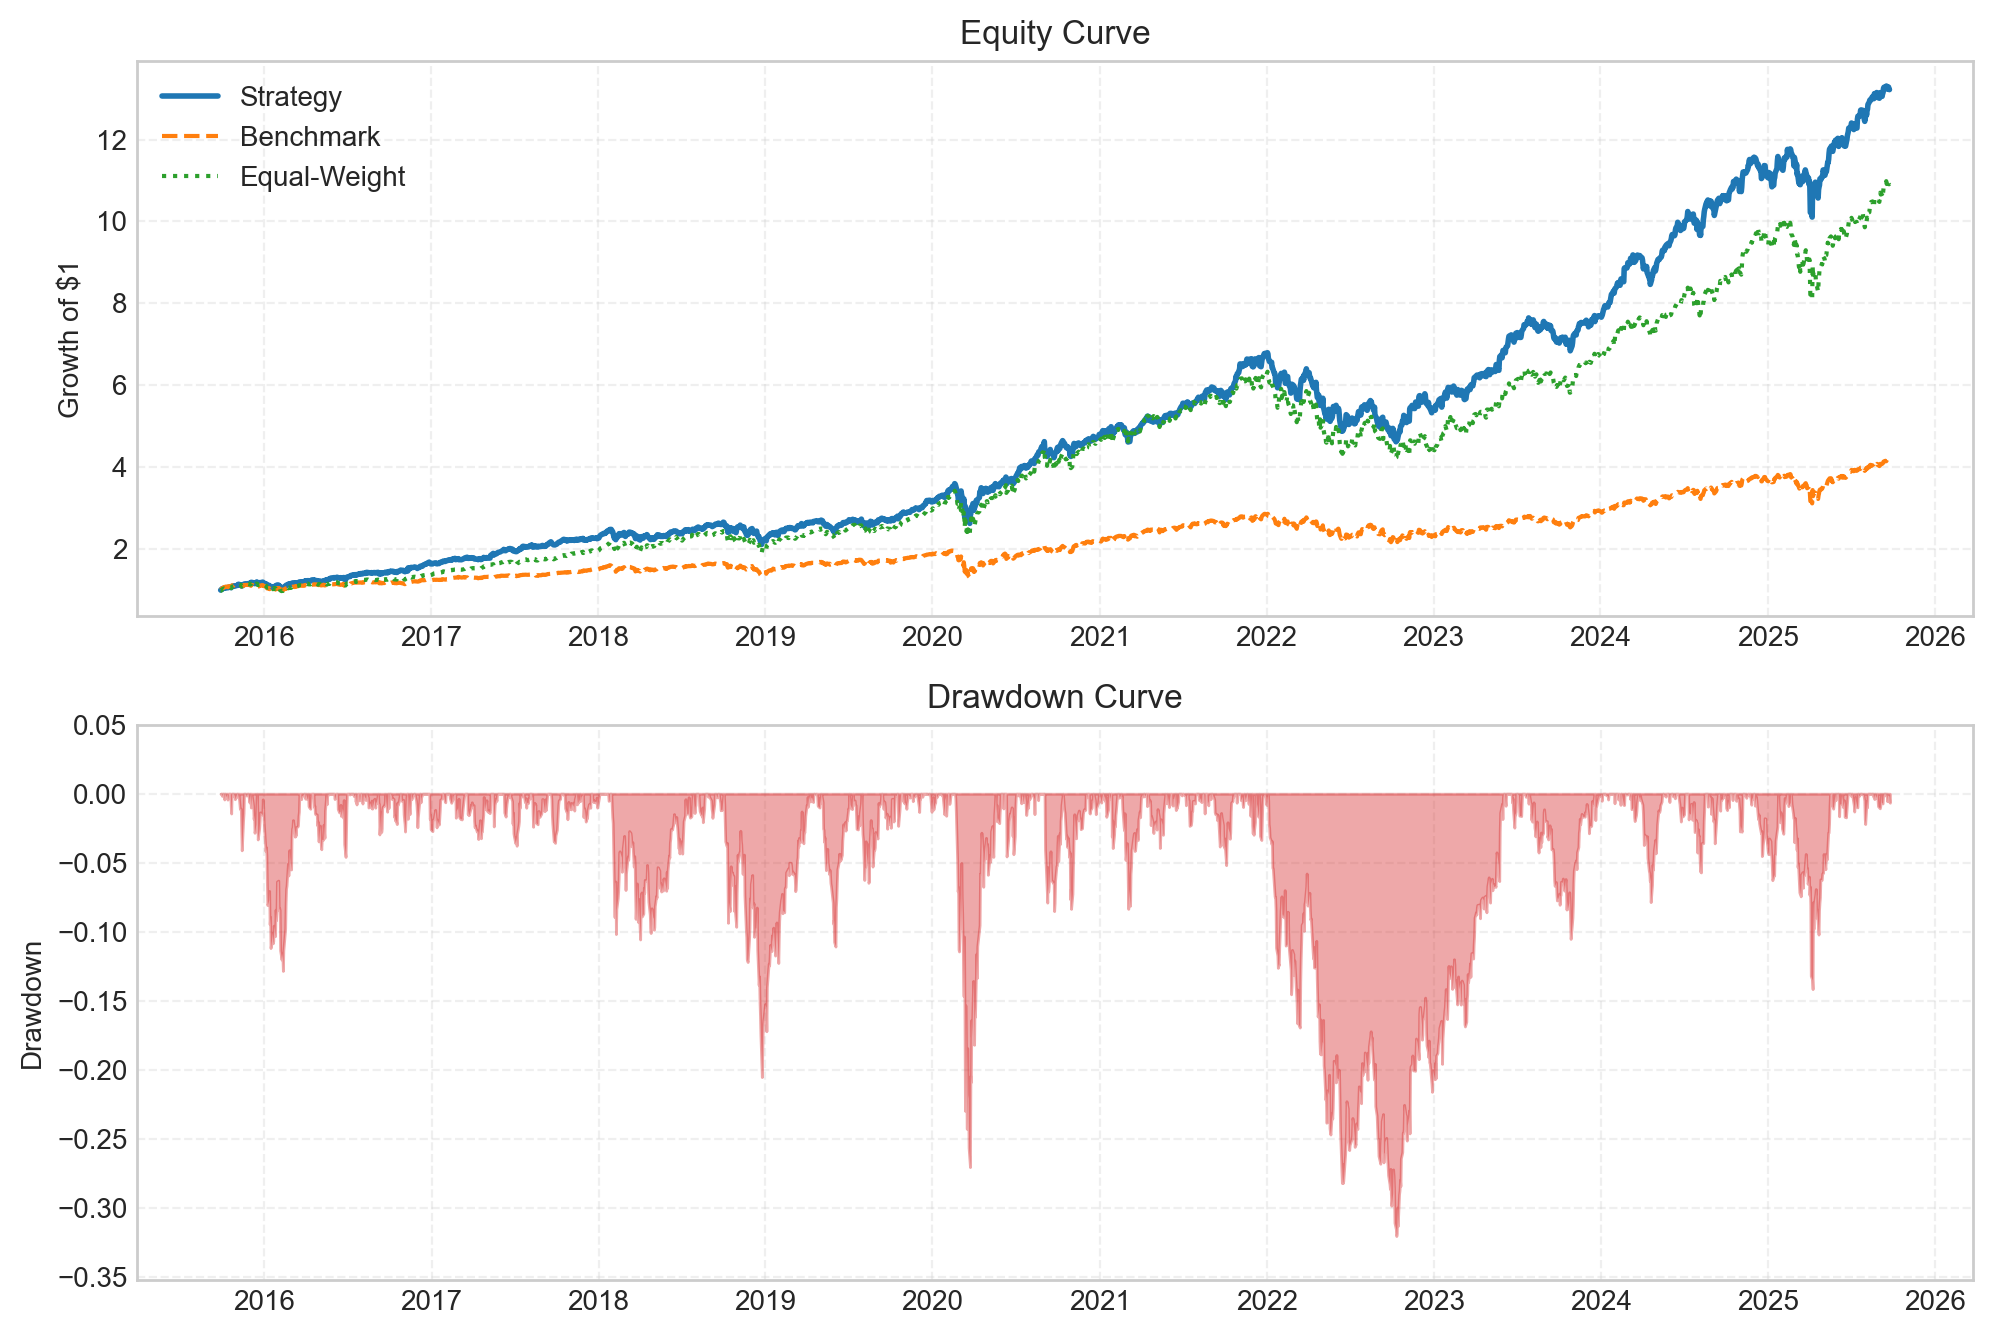

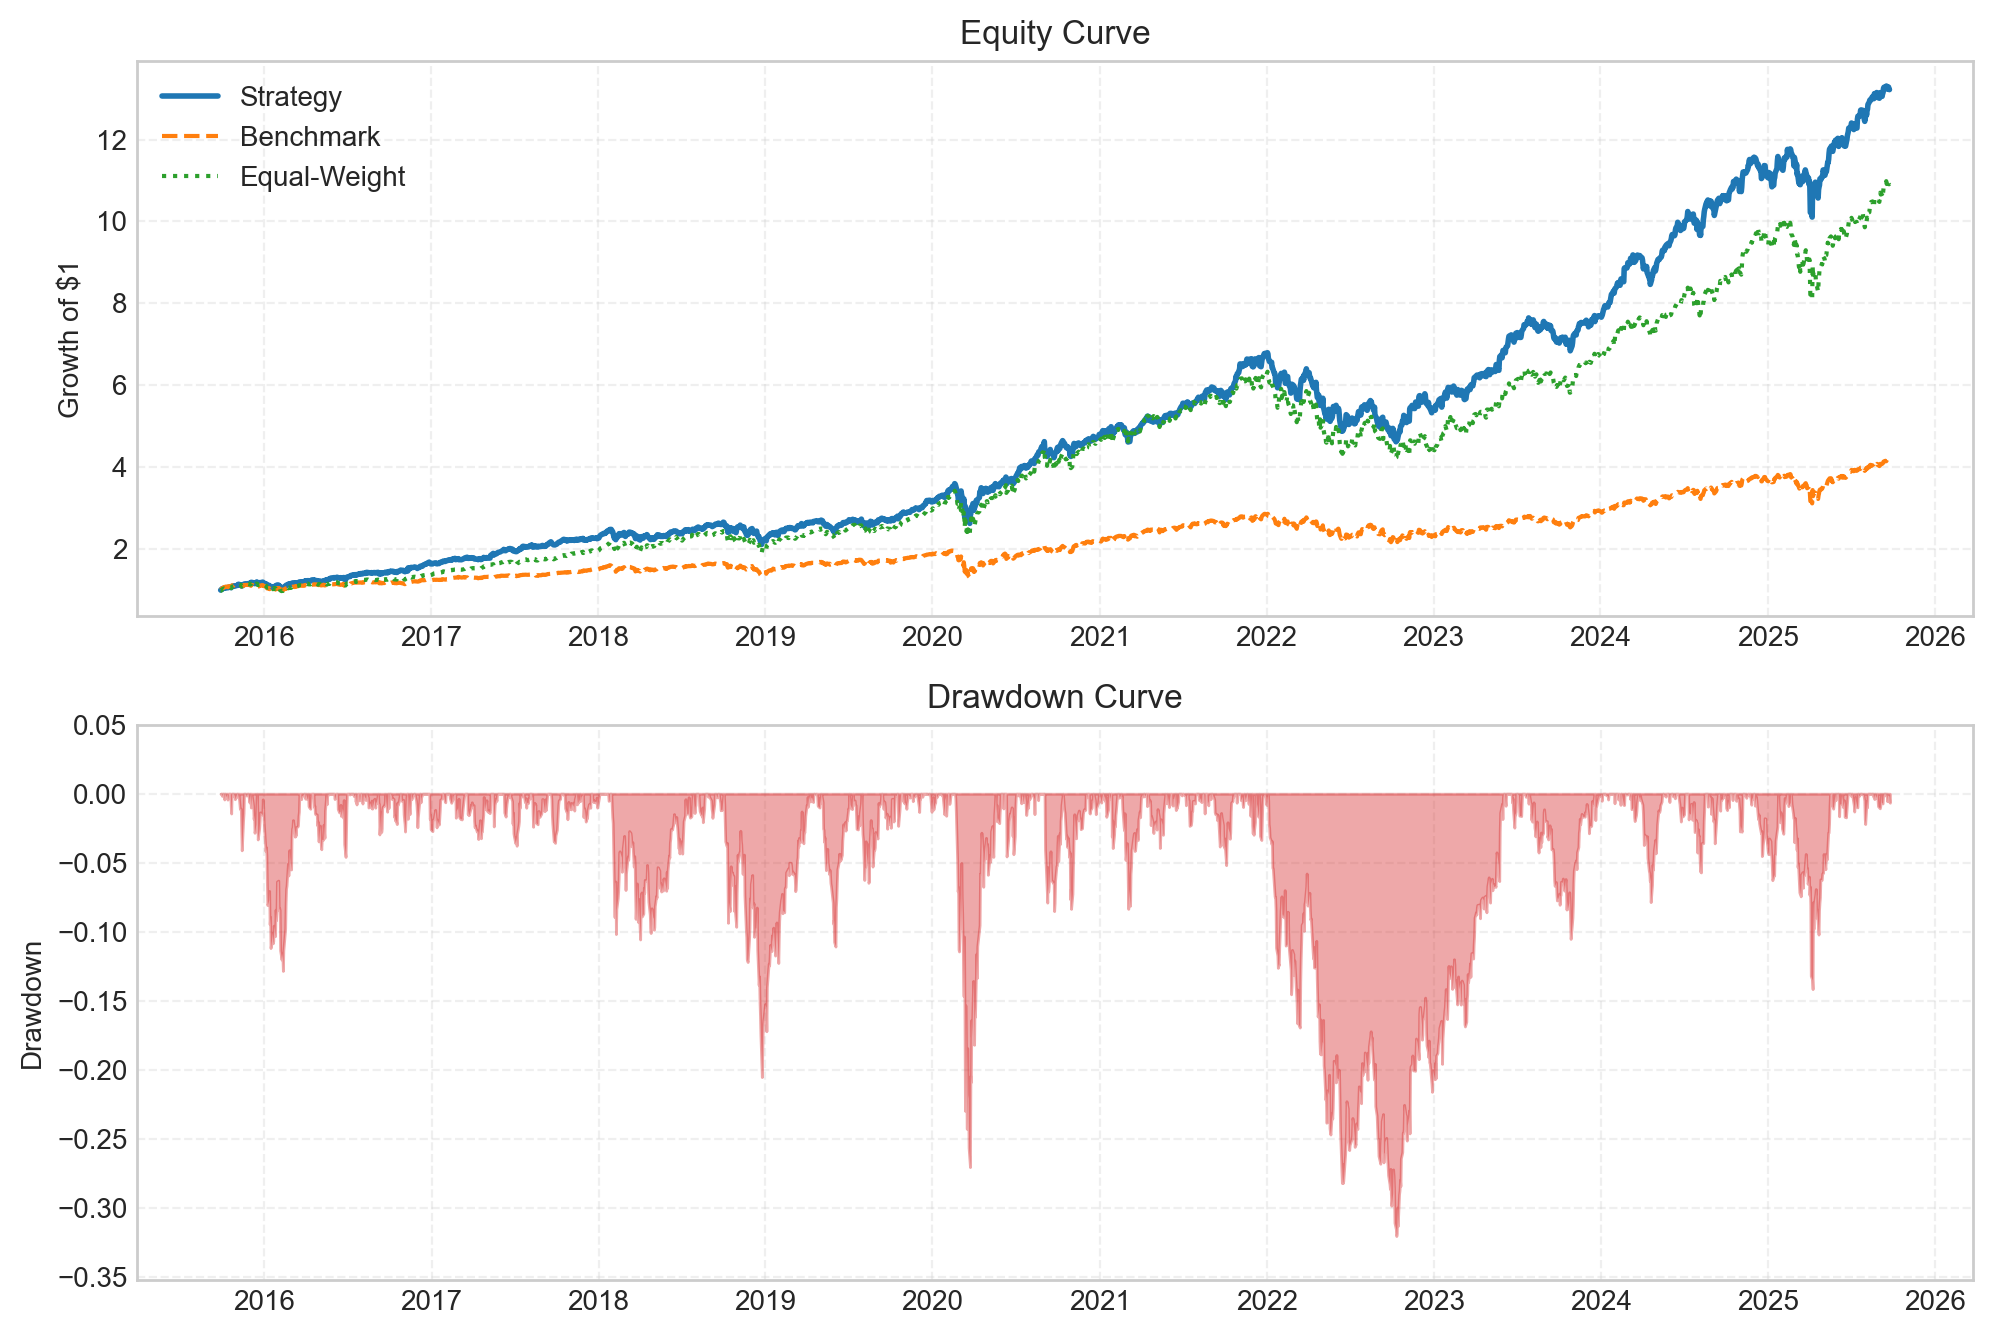

In [22]:
# Cell 7: CVaR Portfolio Equity and Drawdown Visualization
# - Create equity curve and drawdown plots for CVaR optimization
# - Include equal-weight portfolio comparison
# - Add performance summary caption with Sharpe and max drawdown
# - Save visualization to output directory for further analysis

# Fix portfolio_returns dependency - use CVaR returns from comprehensive analysis
if 'results' in globals() and 'CVaR' in results:
    portfolio_returns = results['CVaR']['returns']
    print("Using CVaR portfolio returns from comprehensive analysis")
elif 'cvar' in globals():
    portfolio_returns = (asset_returns * pd.Series(cvar['weights'])).sum(axis=1)
    print("Using standalone CVaR portfolio returns")
else:
    # Fallback to equal weight portfolio
    equal_weights = pd.Series(1.0/len(asset_returns.columns), index=asset_returns.columns)
    portfolio_returns = (asset_returns * equal_weights).sum(axis=1)
    print("Using equal weight portfolio returns as fallback")

fig, axes = plt.subplots(2, 1, figsize=(10, 7))
plot_equity_curve(portfolio_returns, benchmark_returns, ax=axes[0])
# Add equal-weight curve for comparison
try:
    from portfolio.performance.visualization import prepare_equity_curve
    ew_weights = pd.Series(1.0/asset_returns.shape[1], index=asset_returns.columns)
    ew_returns = (asset_returns * ew_weights).sum(axis=1)
    ew_curve = prepare_equity_curve(ew_returns)
    axes[0].plot(ew_curve.index, ew_curve.values, label="Equal-Weight", linestyle=":")
    axes[0].legend(loc="best")
except Exception:
    pass

plot_drawdown_curve(portfolio_returns, ax=axes[1])

# Caption under the figure with Sharpe and Max Drawdown
try:
    sharpe_val = float(standardized_metrics.get("sharpe_ratio", 0.0))
    mdd_val = float(standardized_metrics.get("max_drawdown", 0.0))
    fig.text(0.5, 0.01, f"Sharpe = {sharpe_val:.2f} | Max Drawdown = {mdd_val:.2f}",
             ha="center", va="bottom", fontsize=10, color="dimgray")
except Exception:
    pass

plt.tight_layout(rect=[0, 0.03, 1, 1])
from IPython.display import display
# Handle display(fig) gracefully for non-interactive environments
try:
    display(fig)
except Exception:
    # Silently handle the case where display is not available
    pass

# Save figure (overwrite existing path)
fig.savefig(os.path.join(FIG_DIR, "equity_and_drawdown.png"), dpi=150)

In [23]:
# Cell 8: Parameter Grid Search for MVO Optimization
# - Test different risk models, weight caps, and entropy penalties
# - Expanded weight cap range for better diversification with 16 assets
# - Standardize metrics to decimal format
# - Display top configurations and filtered results

# Updated parameter grid with expanded weight cap range
from itertools import product

risk_models = ["sample", "ledoit_wolf", "oas"]
weight_caps = [None, 0.40, 0.35, 0.30, 0.25, 0.20]  # Expanded range for 16 assets
entropy_penalties = [0.0, 0.01, 0.02, 0.03]   # Moderate entropy range

records = []
for rm, cap, ent in product(risk_models, weight_caps, entropy_penalties):
    res = opt.mean_variance_optimize(
        asset_returns,
        risk_model=rm,
        weight_cap=cap,
        entropy_penalty=ent,
    )
    # Standardize metrics to decimals for consistency
    record = {
        "risk_model": rm,
        "weight_cap": cap,
        "weight_cap_display": ("unconstrained" if cap is None else cap),
        "entropy": ent,
        "sharpe": float(res.get("sharpe_ratio", 0)),
        "vol": float(res.get("expected_volatility", 0)) / 100.0,  # Convert to decimal
        "ret": float(res.get("expected_return", 0)) / 100.0,      # Convert to decimal
    }
    records.append(record)

summary = pd.DataFrame(records)
view = summary.sort_values(by=["sharpe", "ret"], ascending=[False, False])[
    ["risk_model", "weight_cap_display", "entropy", "sharpe", "vol", "ret"]
].rename(columns={"weight_cap_display": "weight_cap"})

# Helpful filtered views
constrained = view[view["weight_cap"] != "unconstrained"]
focus_025 = view.query("weight_cap == 0.25")

with pd.option_context('display.float_format', lambda x: f'{x:.6f}'):
    print("Top overall (in-sample):\n" + view.head(12).to_string(index=False))
    if not constrained.empty:
        print("\nTop constrained (cap != unconstrained):\n" + constrained.head(12).to_string(index=False))
    if not focus_025.empty:
        print("\nFocus on cap = 0.25 (balanced constraint):\n" + focus_025.sort_values(["sharpe","ret"], ascending=[False, False]).to_string(index=False))

Top overall (in-sample):
 risk_model    weight_cap  entropy   sharpe      vol      ret
ledoit_wolf unconstrained 0.030000 1.376223 0.004858 0.006885
        oas unconstrained 0.030000 1.373681 0.004867 0.006885
     sample unconstrained 0.030000 1.372401 0.004871 0.006885
ledoit_wolf unconstrained 0.020000 1.368851 0.004931 0.006950
        oas unconstrained 0.020000 1.366386 0.004940 0.006950
     sample unconstrained 0.020000 1.365137 0.004945 0.006950
ledoit_wolf unconstrained 0.010000 1.363793 0.004976 0.006986
ledoit_wolf unconstrained 0.000000 1.363591 0.004978 0.006988
        oas unconstrained 0.010000 1.361360 0.004985 0.006986
        oas unconstrained 0.000000 1.361159 0.004987 0.006988
     sample unconstrained 0.010000 1.360118 0.004989 0.006986
     sample unconstrained 0.000000 1.359915 0.004991 0.006988

Top constrained (cap != unconstrained):
 risk_model weight_cap  entropy   sharpe      vol      ret
ledoit_wolf   0.300000 0.030000 1.297748 0.003524 0.004773
ledoit_wol

[*********************100%***********************]  16 of 16 completed


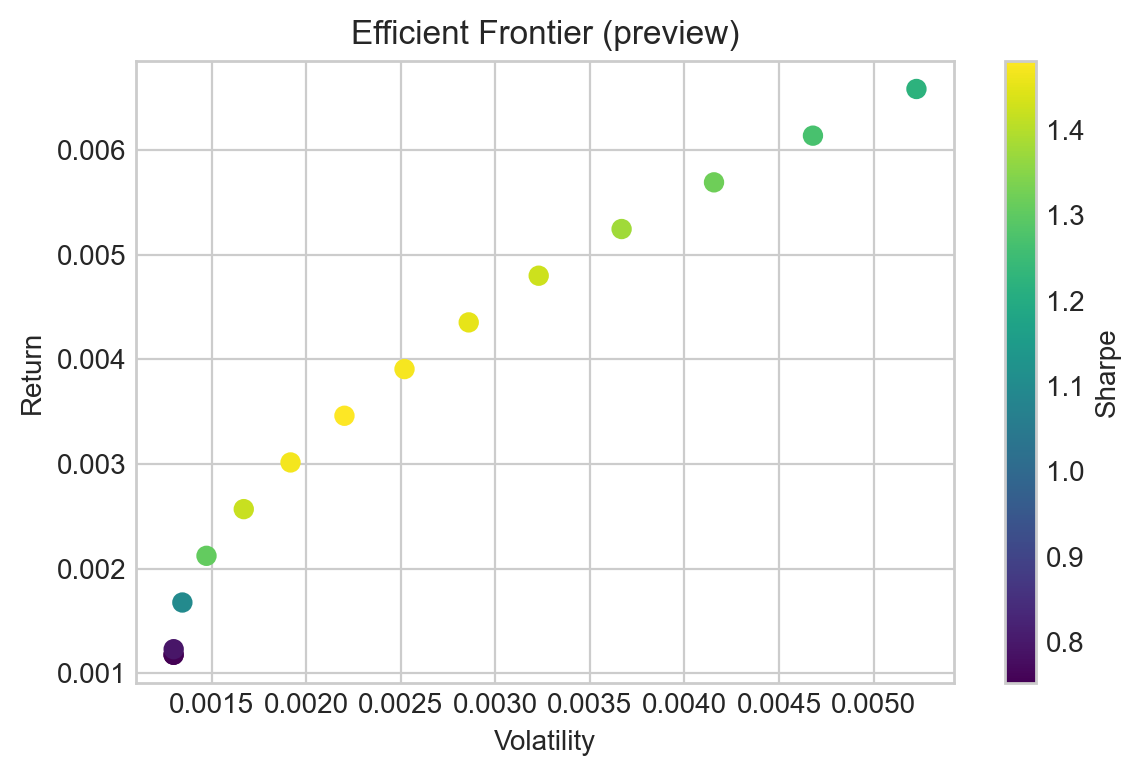

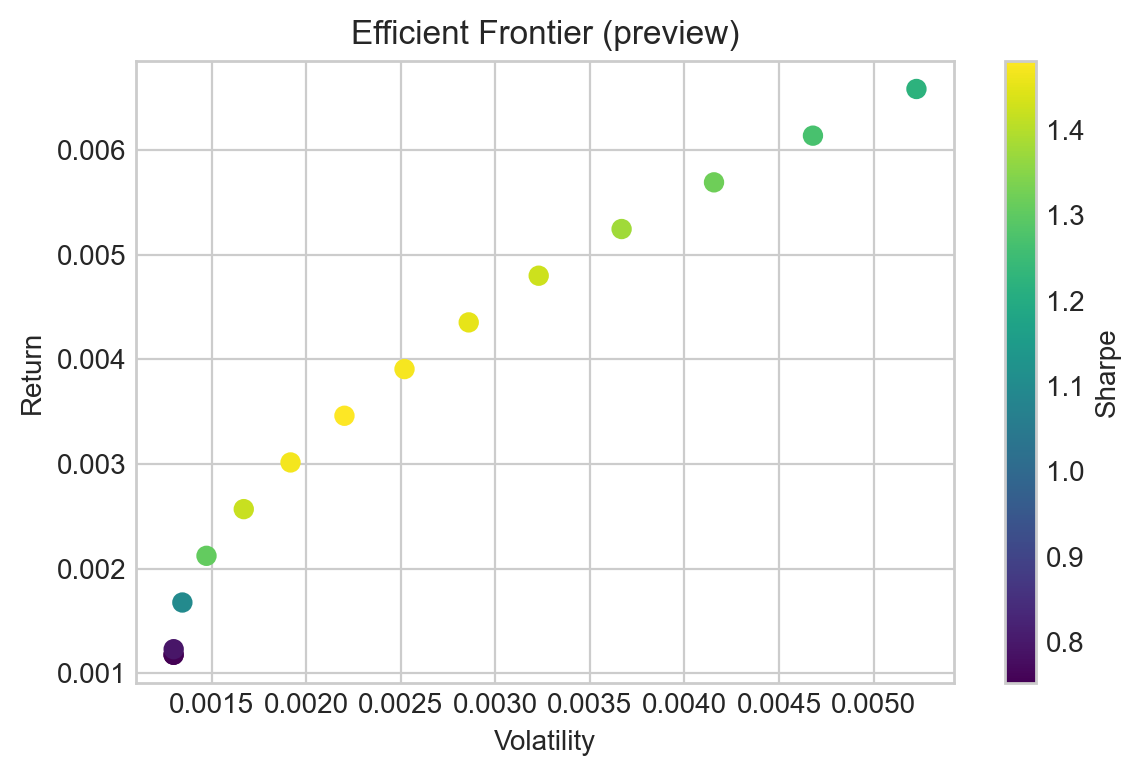

In [24]:
# Cell 9: Efficient Frontier Analysis
# - Generate efficient frontier points using MVO
# - Standardize metrics to decimal format for consistency
# - Create scatter plot colored by Sharpe ratio
# - Save visualization for portfolio optimization reference

# Efficient frontier preview
frontier = opt.get_efficient_frontier(symbols, n_points=15)

if frontier:
    fr = pd.DataFrame(frontier)
    # Standardize return and volatility to decimals for consistency
    fr['return'] = fr['return'] / 100.0
    fr['volatility'] = fr['volatility'] / 100.0
    fig, ax = plt.subplots(figsize=(6,4))
    sc = ax.scatter(fr["volatility"], fr["return"], c=fr["sharpe_ratio"], cmap="viridis", s=40)
    ax.set_xlabel("Volatility")
    ax.set_ylabel("Return")
    ax.set_title("Efficient Frontier (preview)")
    cbar = plt.colorbar(sc, ax=ax, label="Sharpe")
    plt.tight_layout()
    from IPython.display import display
    # Handle display(fig) gracefully for non-interactive environments
    try:
        display(fig)
    except Exception:
        # Silently handle the case where display is not available
        pass
    fig.savefig(os.path.join(FIG_DIR, "efficient_frontier.png"), dpi=150)
else:
    print("Efficient frontier not available (insufficient data).")

In [25]:
# Cell 10: Machine Learning Model Training and Evaluation
# - Train XGBoost models on multiple symbols for return prediction
# - Create features from historical price data using ML predictors
# - Evaluate model performance with test R², CV MSE, and directional accuracy
# - Display comprehensive results table sorted by performance
# - Uses ML configuration variables defined in Cell 1

# Multi-symbol training over long history (per-symbol metrics)
import time
import logging
import pandas as pd
from portfolio.data.yahoo_service import YahooFinanceService
from portfolio.ml import RandomForestPredictor, XGBoostPredictor

logging.basicConfig(level=logging.INFO)
service = YahooFinanceService(use_offline_data=True, offline_data_dir="data")

ml_results = []
for sym in ML_SYMBOLS:
    try:
        data = service.fetch_historical_data(sym, period=ML_PERIOD)
        if data is None or data.empty:
            continue

        model = (
            XGBoostPredictor(device=ML_DEVICE)
            if ML_MODEL == "xgb"
            else RandomForestPredictor()
        )

        feats = model.create_features(data)
        if feats is None or feats.empty:
            continue
        X, y = model.prepare_features(feats)
        if len(X) < ML_MIN_SAMPLES:
            continue

        t0 = time.time()
        metrics = model.train(X, y)
        val = model.validate_model(X, y)
        elapsed = time.time() - t0

        ml_results.append({
            "symbol": sym,
            "n": int(len(feats)),
            "features": int(X.shape[1]),
            "device": metrics.get("device", "cpu" if ML_MODEL == "rf" else ML_DEVICE),
            "train_r2": float(metrics.get("train_r2", float("nan"))),
            "test_r2": float(metrics.get("test_r2", float("nan"))),
            "cv_mse": float(metrics.get("cv_mse", float("nan"))),
            "directional_accuracy": float(val.get("directional_accuracy", float("nan"))),
            "sec": round(elapsed, 2),
        })
    except Exception as e:
        logging.warning(f"{sym}: {e}")

ml_results_df = pd.DataFrame(ml_results).sort_values("test_r2", ascending=False)
ml_results_df

2025-09-29 20:00:06,167 - portfolio.data.yahoo_service - INFO - Initialized YahooFinanceService
2025-09-29 20:00:06,176 - portfolio.data.yahoo_service - INFO - Loaded offline data for AAPL (10y): 2514 rows
2025-09-29 20:00:06,188 - portfolio.ml.predictor - INFO - Created 33 features from 2514 rows
2025-09-29 20:00:06,190 - portfolio.ml.predictor - INFO - Prepared 24 features for 2493 samples
2025-09-29 20:00:07,984 - portfolio.ml.predictor - INFO - XGBoost trained (device=cpu). Test R²: -0.1782, CV MSE: 0.000388
2025-09-29 20:00:07,999 - portfolio.data.yahoo_service - INFO - Loaded offline data for MSFT (10y): 2514 rows
2025-09-29 20:00:08,014 - portfolio.ml.predictor - INFO - Created 33 features from 2514 rows
2025-09-29 20:00:08,017 - portfolio.ml.predictor - INFO - Prepared 24 features for 2493 samples
2025-09-29 20:00:09,858 - portfolio.ml.predictor - INFO - XGBoost trained (device=cpu). Test R²: -0.2663, CV MSE: 0.000347
2025-09-29 20:00:09,872 - portfolio.data.yahoo_service - INF

,symbol,n,features,device,train_r2,test_r2,cv_mse,directional_accuracy,sec
13,DIS,2493,24,cpu,0.910455,-0.036726,0.000391,0.828319,1.60
6,TSLA,2493,24,cpu,0.907945,-0.099669,0.001504,0.825913,1.86
15,ADBE,2493,24,cpu,0.920282,-0.142793,0.000592,0.828319,1.60
0,AAPL,2493,24,cpu,0.918847,-0.178235,0.000388,0.829523,1.80
3,AMZN,2493,24,cpu,0.922652,-0.198537,0.000542,0.838347,1.78
5,NVDA,2493,24,cpu,0.923963,-0.216241,0.001205,0.835941,1.82
2,GOOGL,2493,24,cpu,0.916458,-0.242232,0.000355,0.823105,1.88
11,PG,2493,24,cpu,0.913098,-0.258804,0.000178,0.831127,1.64
1,MSFT,2493,24,cpu,0.920854,-0.266333,0.000347,0.832732,1.85
8,MA,2493,24,cpu,0.922686,-0.267870,0.000383,0.827918,1.69


In [26]:
# Cell 11: Walk-Forward Backtesting with ML Overlay
#
# BACKTEST WINDOW JUSTIFICATION:
#
# TRAINING WINDOW (3 years):
# - Captures full market cycles (bull/bear markets)
# - Provides sufficient data for robust ML model training
# - Balances recency with statistical significance
# - Long enough to capture various correlation regimes
# - Standard institutional practice for medium-frequency strategies
#
# TEST WINDOW (6 months / 2 quarters):
# - Short enough to capture changing market conditions
# - Long enough to generate meaningful performance statistics
# - Balances turnover costs with strategy adaptability
# - Quarterly rebalancing common in institutional portfolios
# - Prevents overfitting to short-term noise
#
# ML OVERLAY CONFIGURATION:
# - Alpha tilt parameter controls ML model influence
# - Recommended alpha from parameter sweep optimization
# - Uses XGBoost for return prediction on technical features
# - Combines traditional optimization with ML signals
#
# BACKTEST EXECUTION:
# - Configure and execute rigorous walk-forward backtesting
# - Include ML overlay with configurable tilt alpha
# - Test multiple optimization strategies with ML enhancement
# - Generate comprehensive backtest performance report

from portfolio.backtesting.walk_forward import BacktestConfig, WalkForwardBacktester

# Try to read recommended ML tilt alpha from previous sweep; default to 0.2 if not present
rec_alpha = 0.2
try:
    rec_path = os.path.join(OUT_DIR, "alpha_sweep_recommendation.txt")
    if os.path.exists(rec_path):
        import re
        with open(rec_path, "r", encoding="utf-8") as f:
            m = re.search(r"alpha .*?([0-9.]+)", f.read())
            if m:
                rec_alpha = float(m.group(1))
except Exception:
    pass

bt_cfg = BacktestConfig(
    train_years=3,      # 3-year training captures full market cycles
    test_quarters=2,    # 6-month test balances adaptability with costs
    include_ml_overlay=True,  # ML enhancement layer
    ml_tilt_alpha=rec_alpha,  # Optimized ML influence
)
backtester = WalkForwardBacktester(bt_cfg)

start_date = (prices.index.min()).strftime("%Y-%m-%d")
end_date = (prices.index.max()).strftime("%Y-%m-%d")

bt_results = backtester.run_backtest(symbols, start_date, end_date)
print("Strategies tested:", list(bt_results.keys()))

report = backtester.generate_report(bt_results)
print(report)

2025-09-29 20:00:34,171 - portfolio.optimizer.optimizer - INFO - Initialized SimplePortfolioOptimizer
2025-09-29 20:00:34,171 - portfolio.data.yahoo_service - INFO - Initialized YahooFinanceService
2025-09-29 20:00:34,171 - portfolio.backtesting.walk_forward - INFO - Initialized WalkForwardBacktester with 3y train, 2q test, 7.5bps costs
2025-09-29 20:00:34,172 - portfolio.backtesting.walk_forward - INFO - Fetching data for 16 symbols from 2015-09-25 to 2025-09-24
2025-09-29 20:00:34,179 - portfolio.data.yahoo_service - INFO - Loaded offline data for AAPL (5y): 1255 rows
2025-09-29 20:00:34,186 - portfolio.data.yahoo_service - INFO - Loaded offline data for MSFT (5y): 1255 rows
2025-09-29 20:00:34,192 - portfolio.data.yahoo_service - INFO - Loaded offline data for GOOGL (5y): 1255 rows
2025-09-29 20:00:34,198 - portfolio.data.yahoo_service - INFO - Loaded offline data for AMZN (5y): 1255 rows
2025-09-29 20:00:34,203 - portfolio.data.yahoo_service - INFO - Loaded offline data for META (5

Strategies tested: ['mv_unconstrained', 'mv_capped_18', 'cvar_capped_20', 'black_litterman_capped_20', 'equal_weight', 'ml_overlay', 'optimized', 'spy', 'comparison']
WALK-FORWARD BACKTESTING REPORT

Configuration:
  Training Period: 3 year(s)
  Testing Period: 2 quarter(s)
  Transaction Costs: 7.5 bps
  Rebalance Frequency: quarterly

--- MV_UNCONSTRAINED STRATEGY ---
Performance Metrics:
  Total Return: 31.38%
  Annual Return: 50.23%
  Annual Volatility: 43.11%
  Sharpe Ratio: 1.12
  Sortino Ratio: 1.75
  Max Drawdown: -30.02%
  Calmar Ratio: 1.67

Trading Metrics:
  Total Transaction Costs: 0.0750%
  Annual Turnover: 99.98%
  Win Rate: 53.8%

--- MV_CAPPED_18 STRATEGY ---
Performance Metrics:
  Total Return: 20.67%
  Annual Return: 32.34%
  Annual Volatility: 31.05%
  Sharpe Ratio: 0.98
  Sortino Ratio: 1.53
  Max Drawdown: -20.17%
  Calmar Ratio: 1.60

Trading Metrics:
  Total Transaction Costs: 0.0543%
  Annual Turnover: 72.44%
  Win Rate: 52.7%

--- CVAR_CAPPED_20 STRATEGY ---
Pe